In [662]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import json
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Функции для обработки данных

In [483]:
def get_info_table_json(column, id):
    df_genres = pd.json_normalize(column.explode())
    df_genres = df_genres.dropna()
    df_genres['duplicate_count'] = df_genres.groupby(id)[id].transform('count')
    df_genres = df_genres.drop_duplicates(subset=id)
    df_genres.sort_values(by='duplicate_count',ascending=False, inplace=True)
    return df_genres

def get_items_from_json(item_name, column_name):
    col = data[column_name].apply(lambda x: ', '.join([item[item_name] for item in x])if x != [] else '')
    return col


# Данные

In [591]:
data = pd.read_csv('../../data/train.csv')
data

id                              belongs_to_collection    budget  \
0        1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1        2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2        3                                                NaN   3300000   
3        4                                                NaN   1200000   
4        5                                                NaN         0   
...    ...                                                ...       ...   
2995  2996                                                NaN         0   
2996  2997                                                NaN         0   
2997  2998                                                NaN  65000000   
2998  2999                                                NaN  42000000   
2999  3000                                                NaN  35000000   

                                                 genres  \
0                        [{'id': 35, 'name': 'Comedy'}]   
1     [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                         [{'id': 18, 'name': 'Drama'}]   
3     [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
...                                                 ...   
2995  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2996  [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...   
2997  [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...   
2998  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2999  [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...   

                               homepage    imdb_id original_language  \
0                                   NaN  tt2637294                en   
1                                   NaN  tt0368933                en   
2     http://sonyclassics.com/whiplash/  tt2582802                en   
3            http://kahaanithefilm.com/  tt1821480                hi   
4                                   NaN  tt1380152                ko   
...                                 ...        ...               ...   
2995                                NaN  tt0109403                en   
2996                                NaN  tt2364975                sv   
2997                                NaN  tt0116908                en   
2998     http://www.alongcamepolly.com/  tt0343135                en   
2999   http://www.abductionthefilm.com/  tt1600195                en   

                                original_title  \
0                       Hot Tub Time Machine 2   
1     The Princess Diaries 2: Royal Engagement   
2                                     Whiplash   
3                                      Kahaani   
4                                         마린보이   
...                                        ...   
2995                                   Chasers   
2996                               Vi är bäst!   
2997                   The Long Kiss Goodnight   
2998                          Along Came Polly   
2999                                 Abduction   

                                               overview  popularity  \
0     When Lou, who has become the "father of the In...    6.575393   
1     Mia Thermopolis is now a college graduate and ...    8.248895   
2     Under the direction of a ruthless instructor, ...   64.299990   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4     Marine Boy is the story of a former national s...    1.148070   
...                                                 ...         ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542   
2999  A young man sets out to uncover the truth abou...   10.512109   

                           poster_path  \
0     /tQtWuwvMf0hCc2QR2tkolwl7c3c.jp

##Рассмотри подробнее колонки Json и изменим их

In [592]:
data.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

###belongs_to_collection

In [593]:
data['belongs_to_collection'] = data['belongs_to_collection'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["belongs_to_collection"][i]}')

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 []
3 []
4 []


In [594]:
data['belongs_to_collection'].apply(lambda x: len(x) if x != [] else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

У всех фильмов 0 или 1 коллекция, поэтому оставим только факт его наличия и имя

In [595]:
data['collection_name'] = data['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != [] else 0)
data['has_collection'] = data['belongs_to_collection'].apply(lambda x: len(x) if x != [] else 0)

###genres

In [596]:
data['genres'] = data['genres'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["genres"][i]}')

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [597]:
info_genres = get_info_table_json(data['genres'], 'id')
info_genres

id             name  duplicate_count
2        18.0            Drama             1531
0        35.0           Comedy             1028
6        53.0         Thriller              789
8        28.0           Action              741
4     10749.0          Romance              571
27       80.0            Crime              469
11       12.0        Adventure              439
13       27.0           Horror              301
30      878.0  Science Fiction              290
3     10751.0           Family              260
77       14.0          Fantasy              232
31     9648.0          Mystery              225
10       16.0        Animation              141
220      36.0          History              132
95    10752.0              War              100
18    10402.0            Music              100
15       99.0      Documentary               87
96       37.0          Western               43
53    10769.0          Foreign               31
4228  10770.0         TV Movie                1

Всего жанров 20, поэтому оставим их все и преобразуем так же как belongs_to_collection, применим к ним one hot encoding

In [598]:
data['genres_names'] = get_items_from_json('name', 'genres')
new_columns = pd.DataFrame(index=data.index)
for g in info_genres['name']:
    new_columns['genre_' + g] = data['genres_names'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

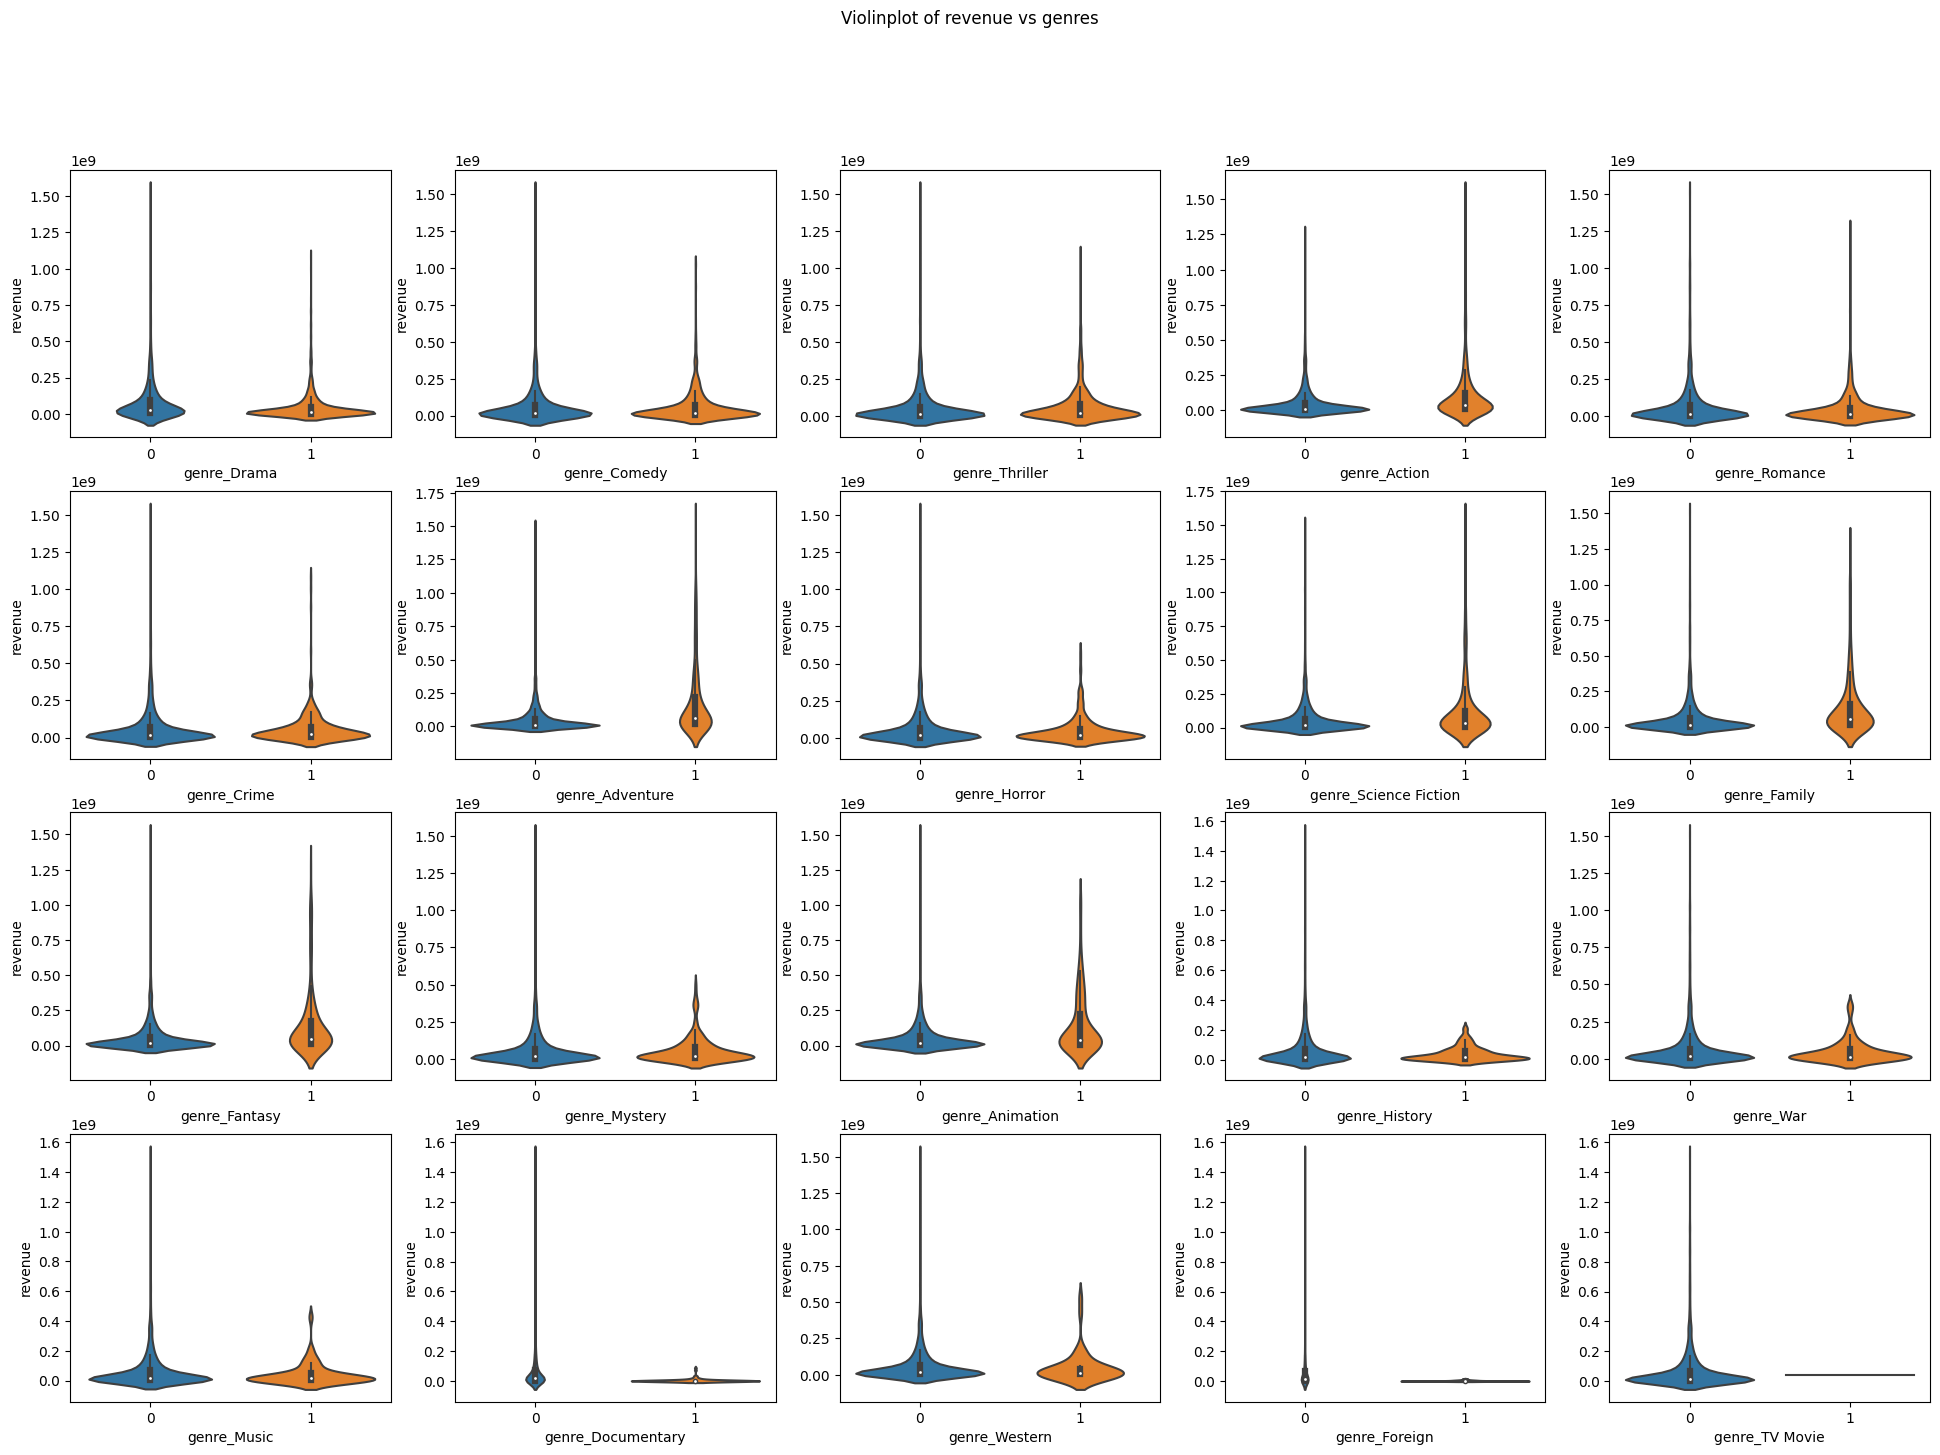

In [599]:
f, axes = plt.subplots(4, 5, figsize=(24, 16))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in data.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

###production_companies

In [600]:
data['production_companies'] = data['production_companies'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["production_companies"][i]}')

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 []
4 []


In [601]:
info_production_companies = get_info_table_json(data['production_companies'], 'id')
info_production_companies

name       id  duplicate_count
128                             Warner Bros.   6194.0              202
68                        Universal Pictures     33.0              188
0                         Paramount Pictures      4.0              161
18    Twentieth Century Fox Film Corporation    306.0              138
157                        Columbia Pictures      5.0               91
...                                      ...      ...              ...
2966                            Zwart Arbeid  44997.0                1
53               Sea Side Films Florida Inc.  95342.0                1
2974                             Archipel 35   2695.0                1
2977                                Eyeworks   6461.0                1
8250                 Quick Six Entertainment  24561.0                1

[3712 rows x 3 columns]

Здесь целых 3712 компании, поэтому оставим самые популярные из них и применим к ним one hot encoding

In [602]:
data['production_companies_names'] = get_items_from_json('name', 'production_companies')
new_columns = pd.DataFrame(index=data.index)
for g in info_production_companies['name'][:30]:
    new_columns['production_company_' + g] = data['production_companies_names'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

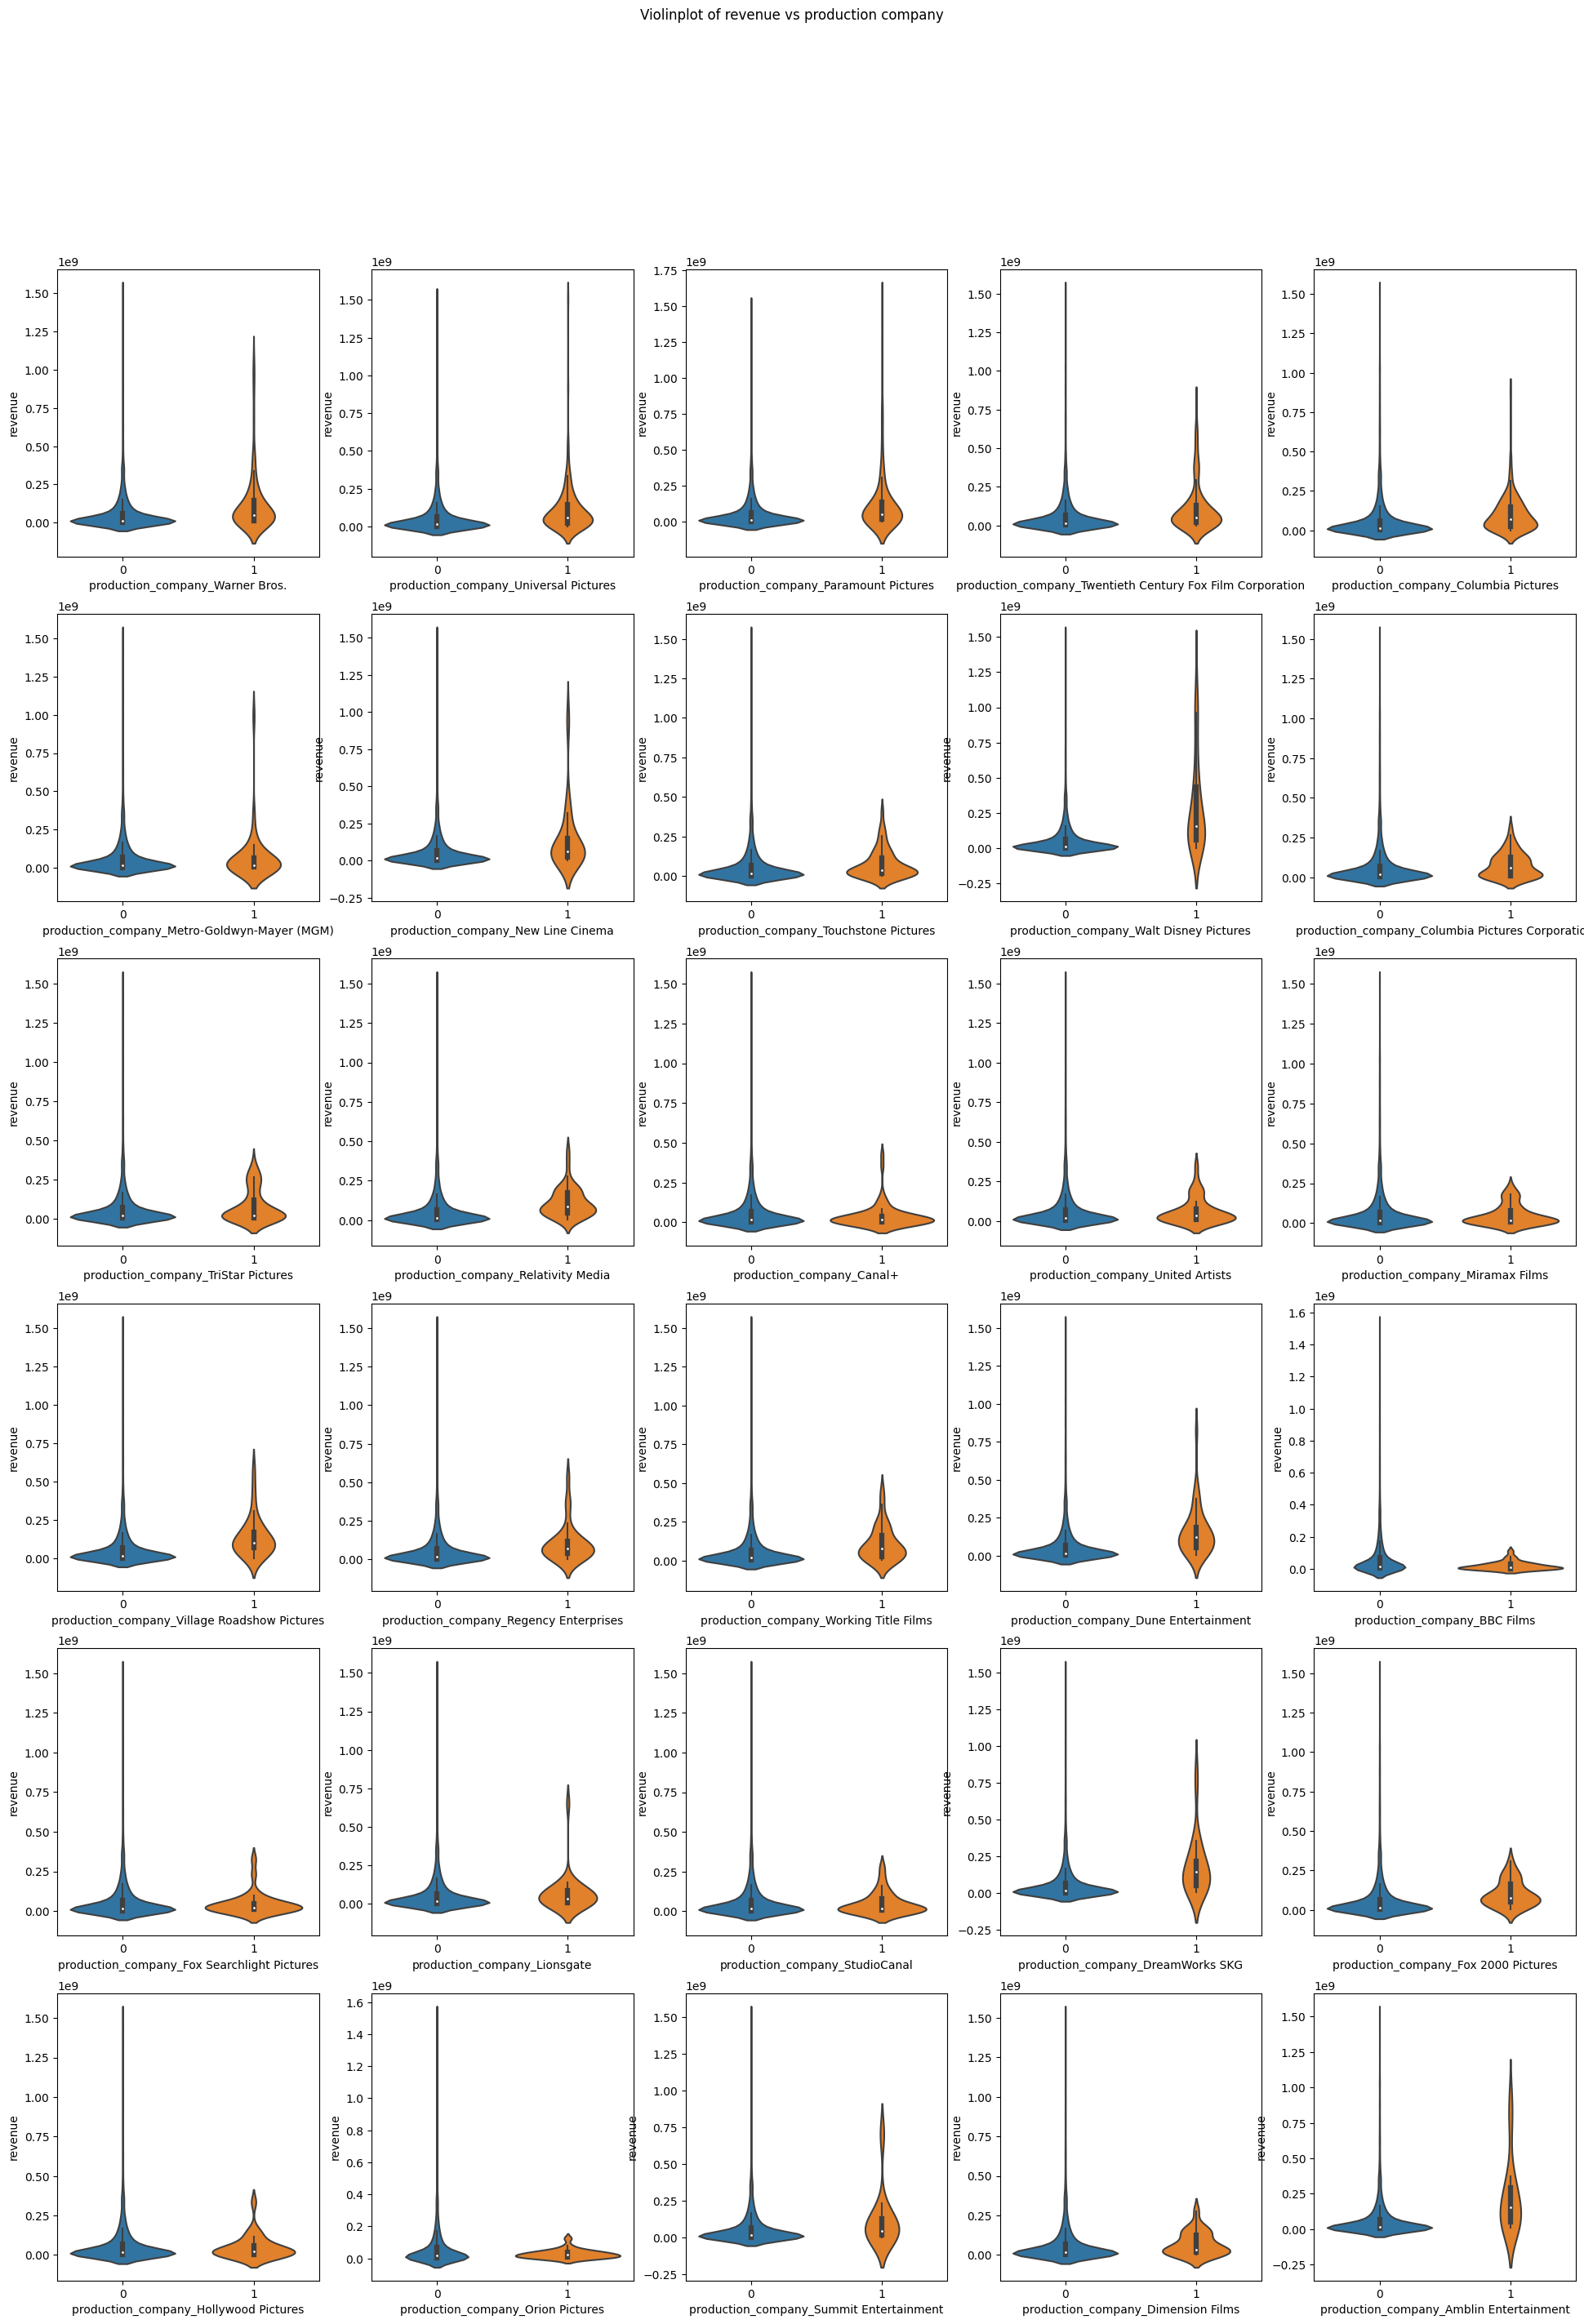

In [603]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in data.columns if 'production_company_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

###production_countries

In [604]:
data['production_countries'] = data['production_countries'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["production_countries"][i]}')

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


Сделаем то же самое, что и с production_companies

In [605]:
info_production_countries = get_info_table_json(data['production_countries'], 'iso_3166_1')
data['production_countries_id'] = get_items_from_json('iso_3166_1', 'production_countries')
data['production_countries_id']
new_columns = pd.DataFrame(index=data.index)
for g in info_production_countries['iso_3166_1'][:30]:
    new_columns['production_country_' + g] = data['production_countries_id'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

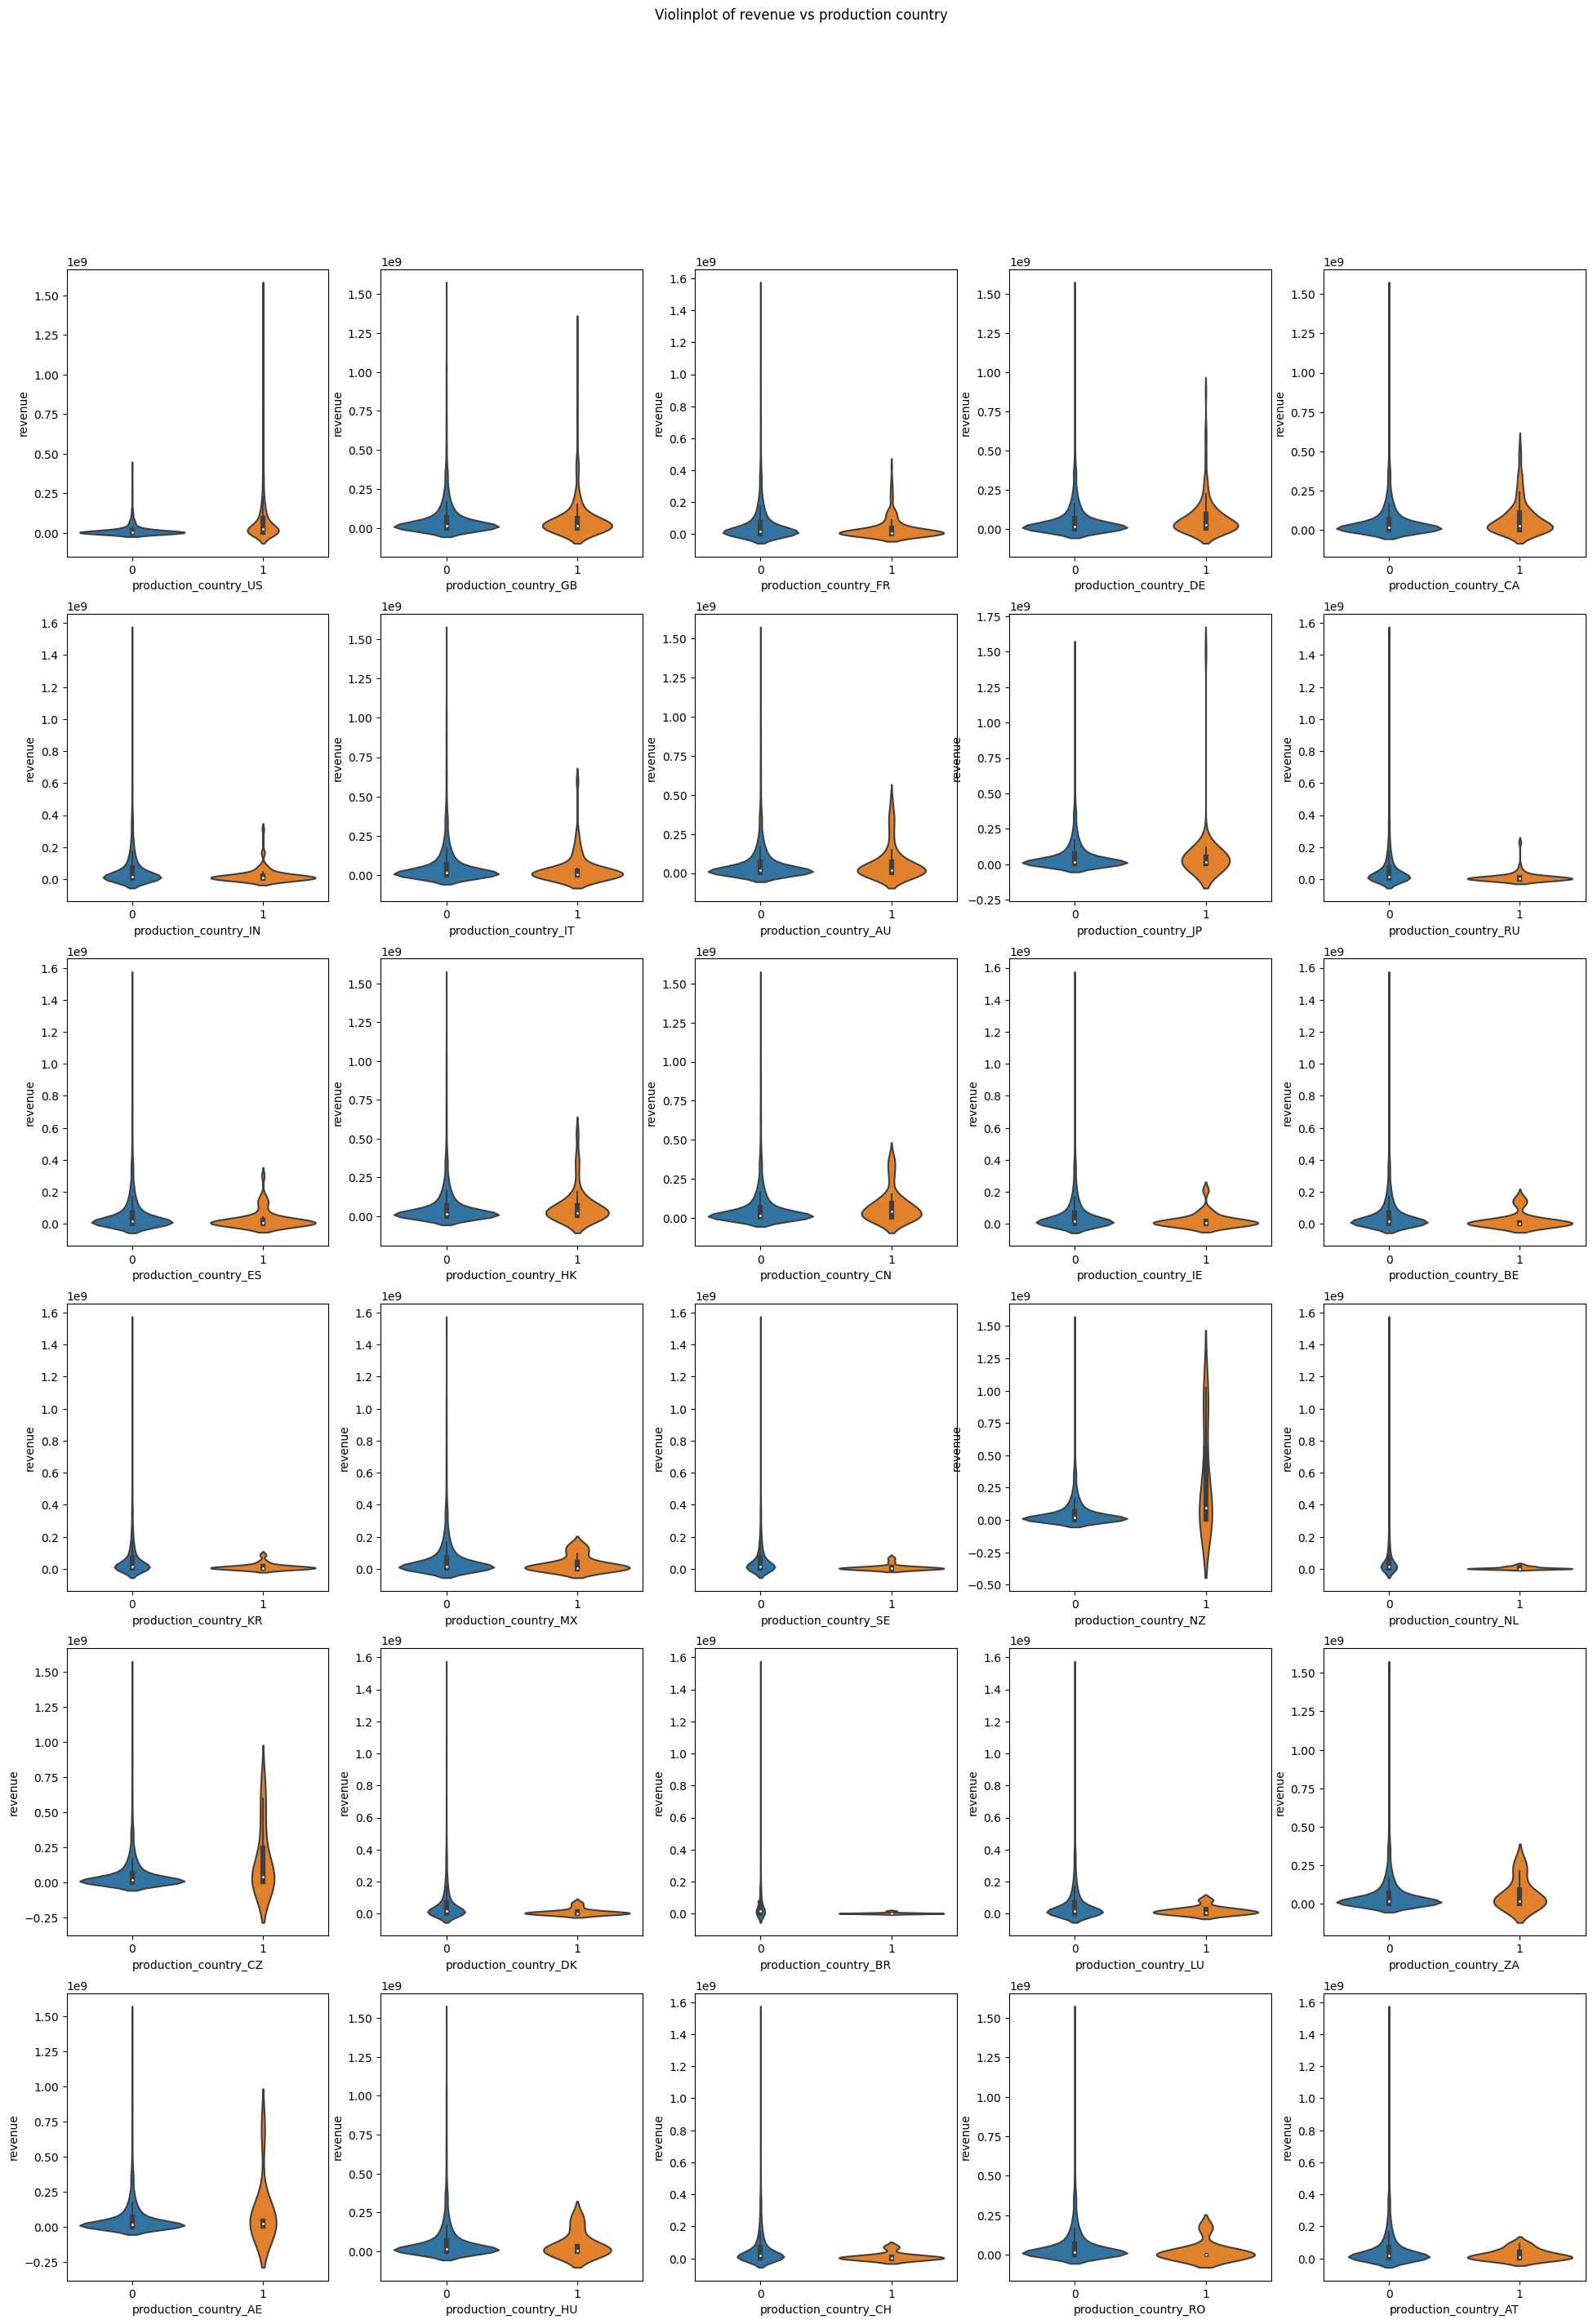

In [606]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in data.columns if 'production_country_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

###spoken_languages

In [607]:
data['spoken_languages'] = data['spoken_languages'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["spoken_languages"][i]}')

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [608]:
info_spoken_languages = get_info_table_json(data['spoken_languages'], 'iso_639_1')
data['spoken_languages_id'] = get_items_from_json('iso_639_1', 'spoken_languages')
new_columns = pd.DataFrame(index=data.index)
for g in info_spoken_languages['iso_639_1'][:30]:
    new_columns['spoken_language_' + g] = data['spoken_languages_id'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

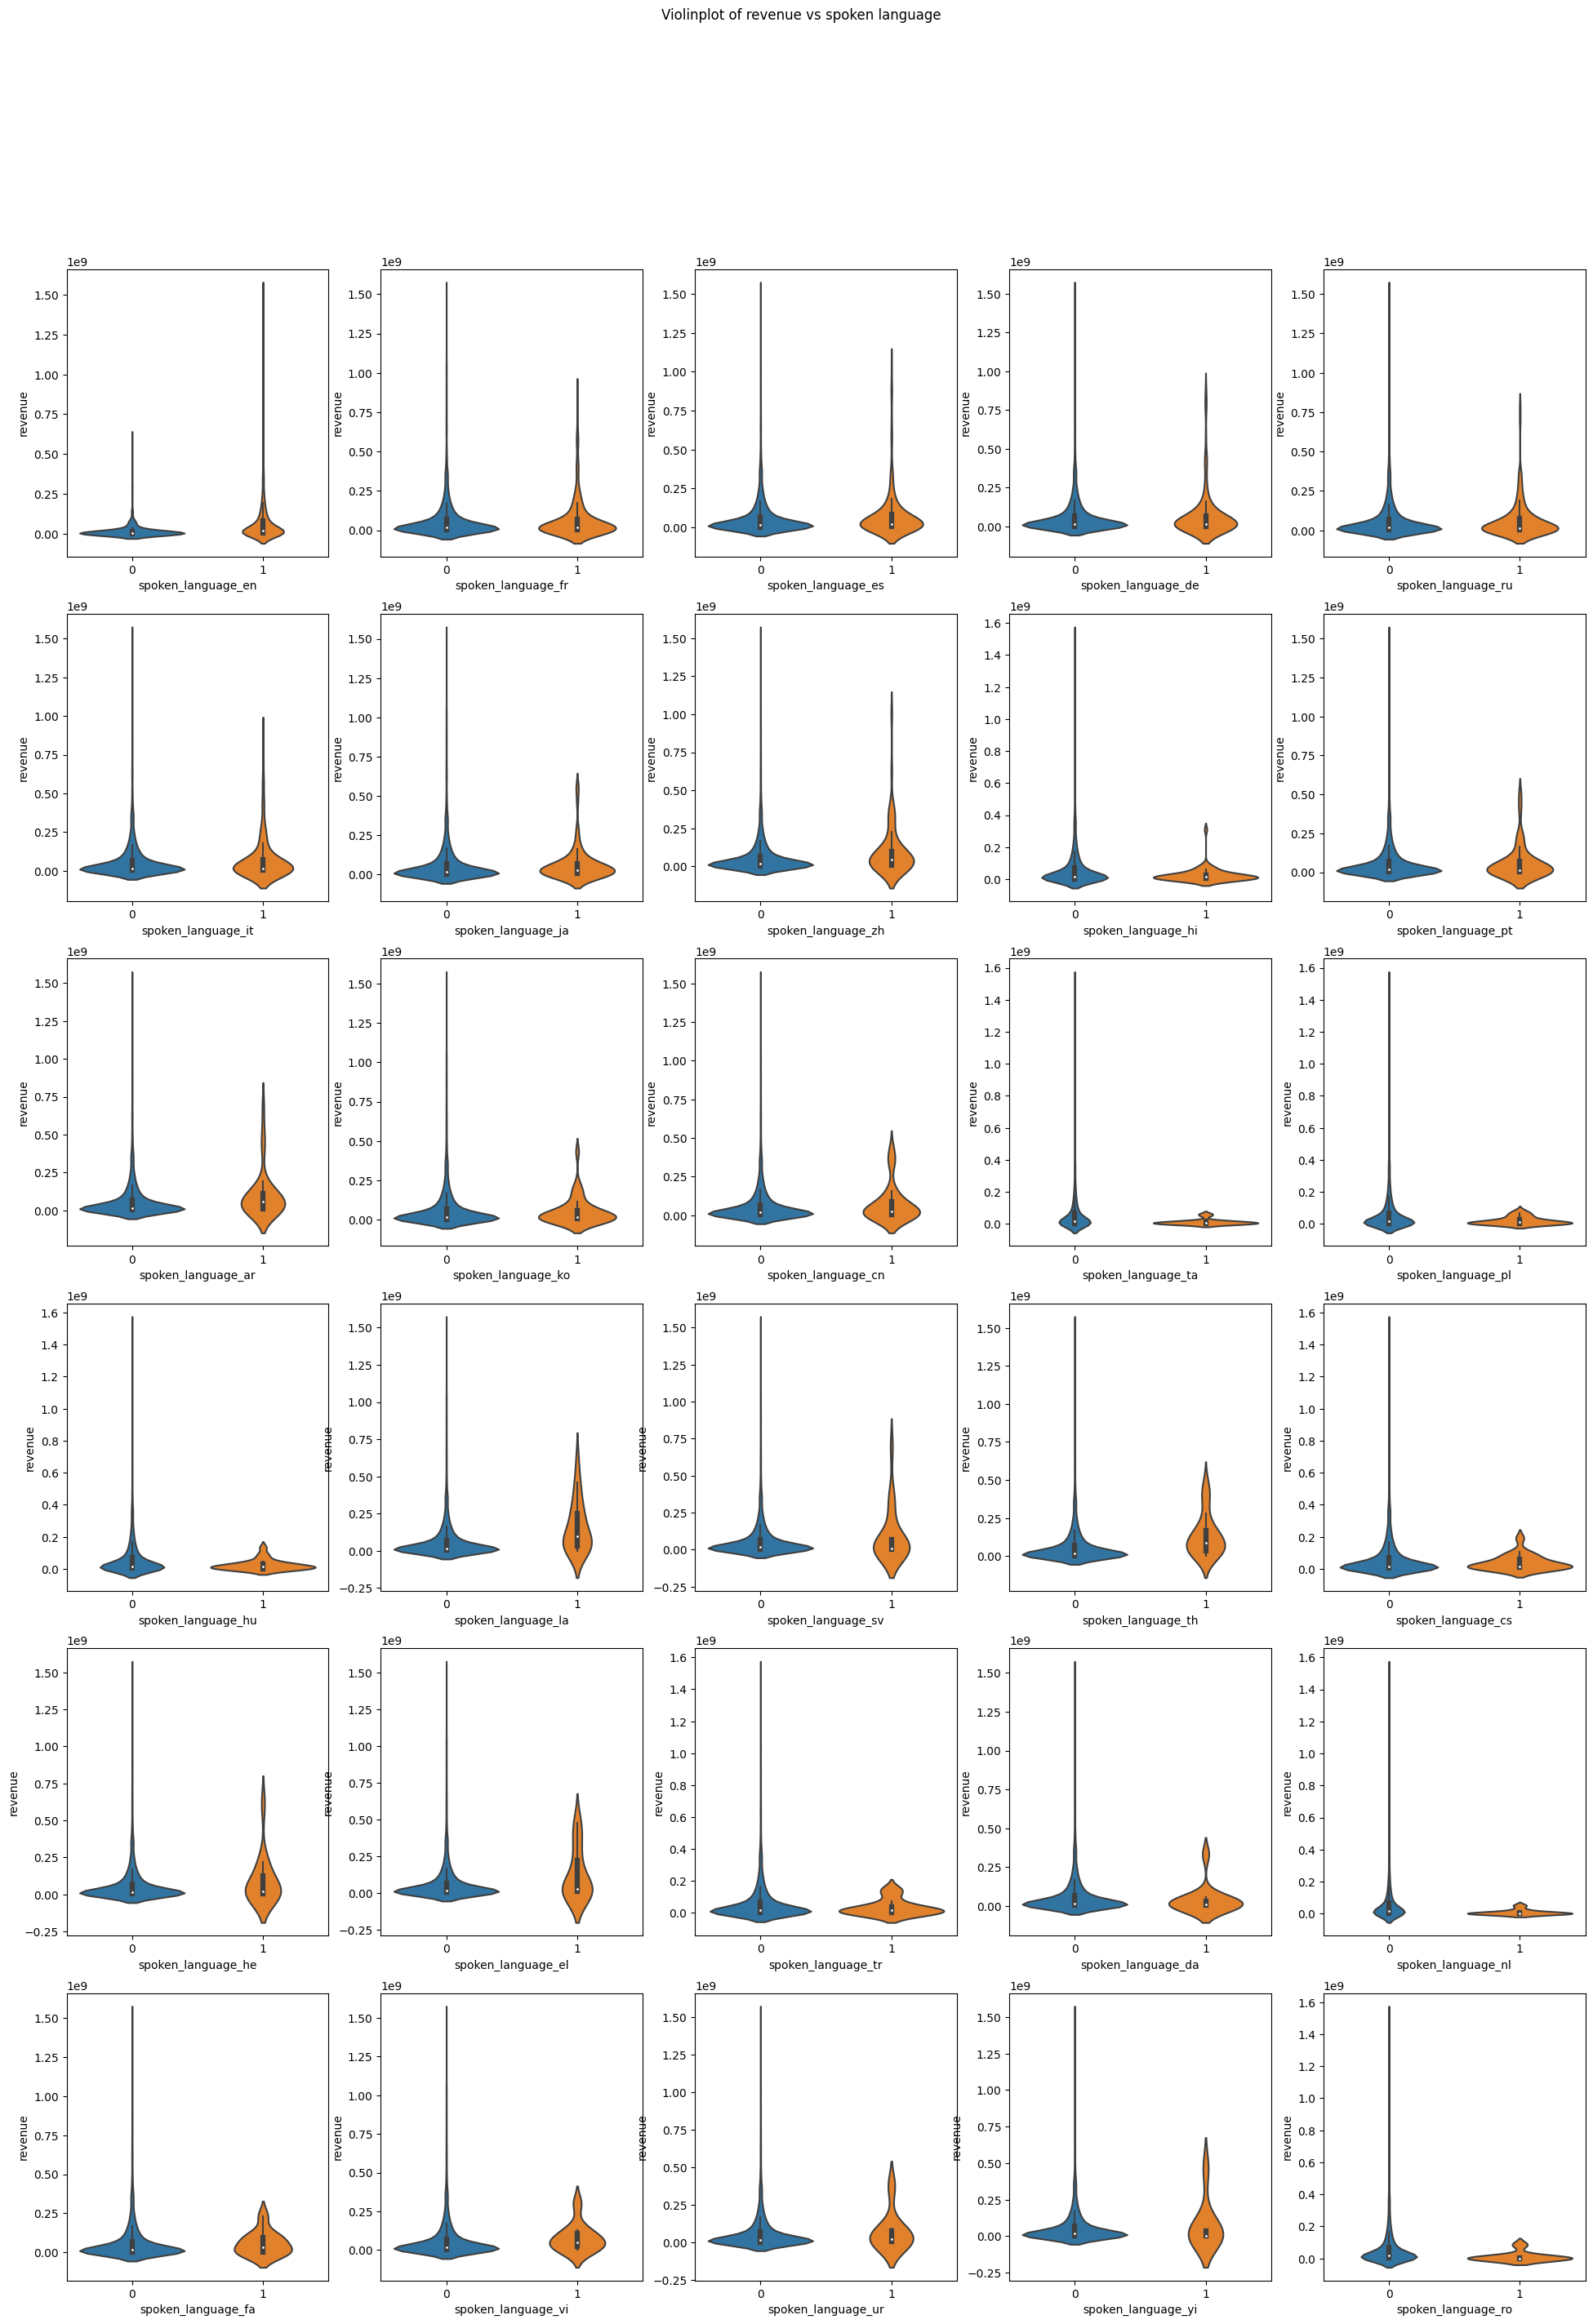

In [609]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs spoken language')
for i, e in enumerate([col for col in data.columns if 'spoken_language_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

###Keywords

In [610]:
data['Keywords'] = data['Keywords'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["Keywords"][i]}')

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [611]:
info_Keywords = get_info_table_json(data['Keywords'], 'id')
info_Keywords

id                    name  duplicate_count
36     187056.0          woman director              175
156     10183.0        independent film              155
3      179431.0    duringcreditsstinger              134
100      9826.0                  murder              123
259       818.0          based on novel              111
...         ...                     ...              ...
8105     4014.0             giant plant                1
8118   193817.0             rollerblade                1
8127     4021.0          business woman                1
8133    33432.0       male masturbation                1
21941  226219.0  insurance risk manager                1

[7400 rows x 3 columns]

In [612]:
data['Keywords_name'] = get_items_from_json('name', 'Keywords')
new_columns = pd.DataFrame(index=data.index)
for g in info_Keywords['name'][:30]:
    new_columns['Keyword_' + g] = data['Keywords_name'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

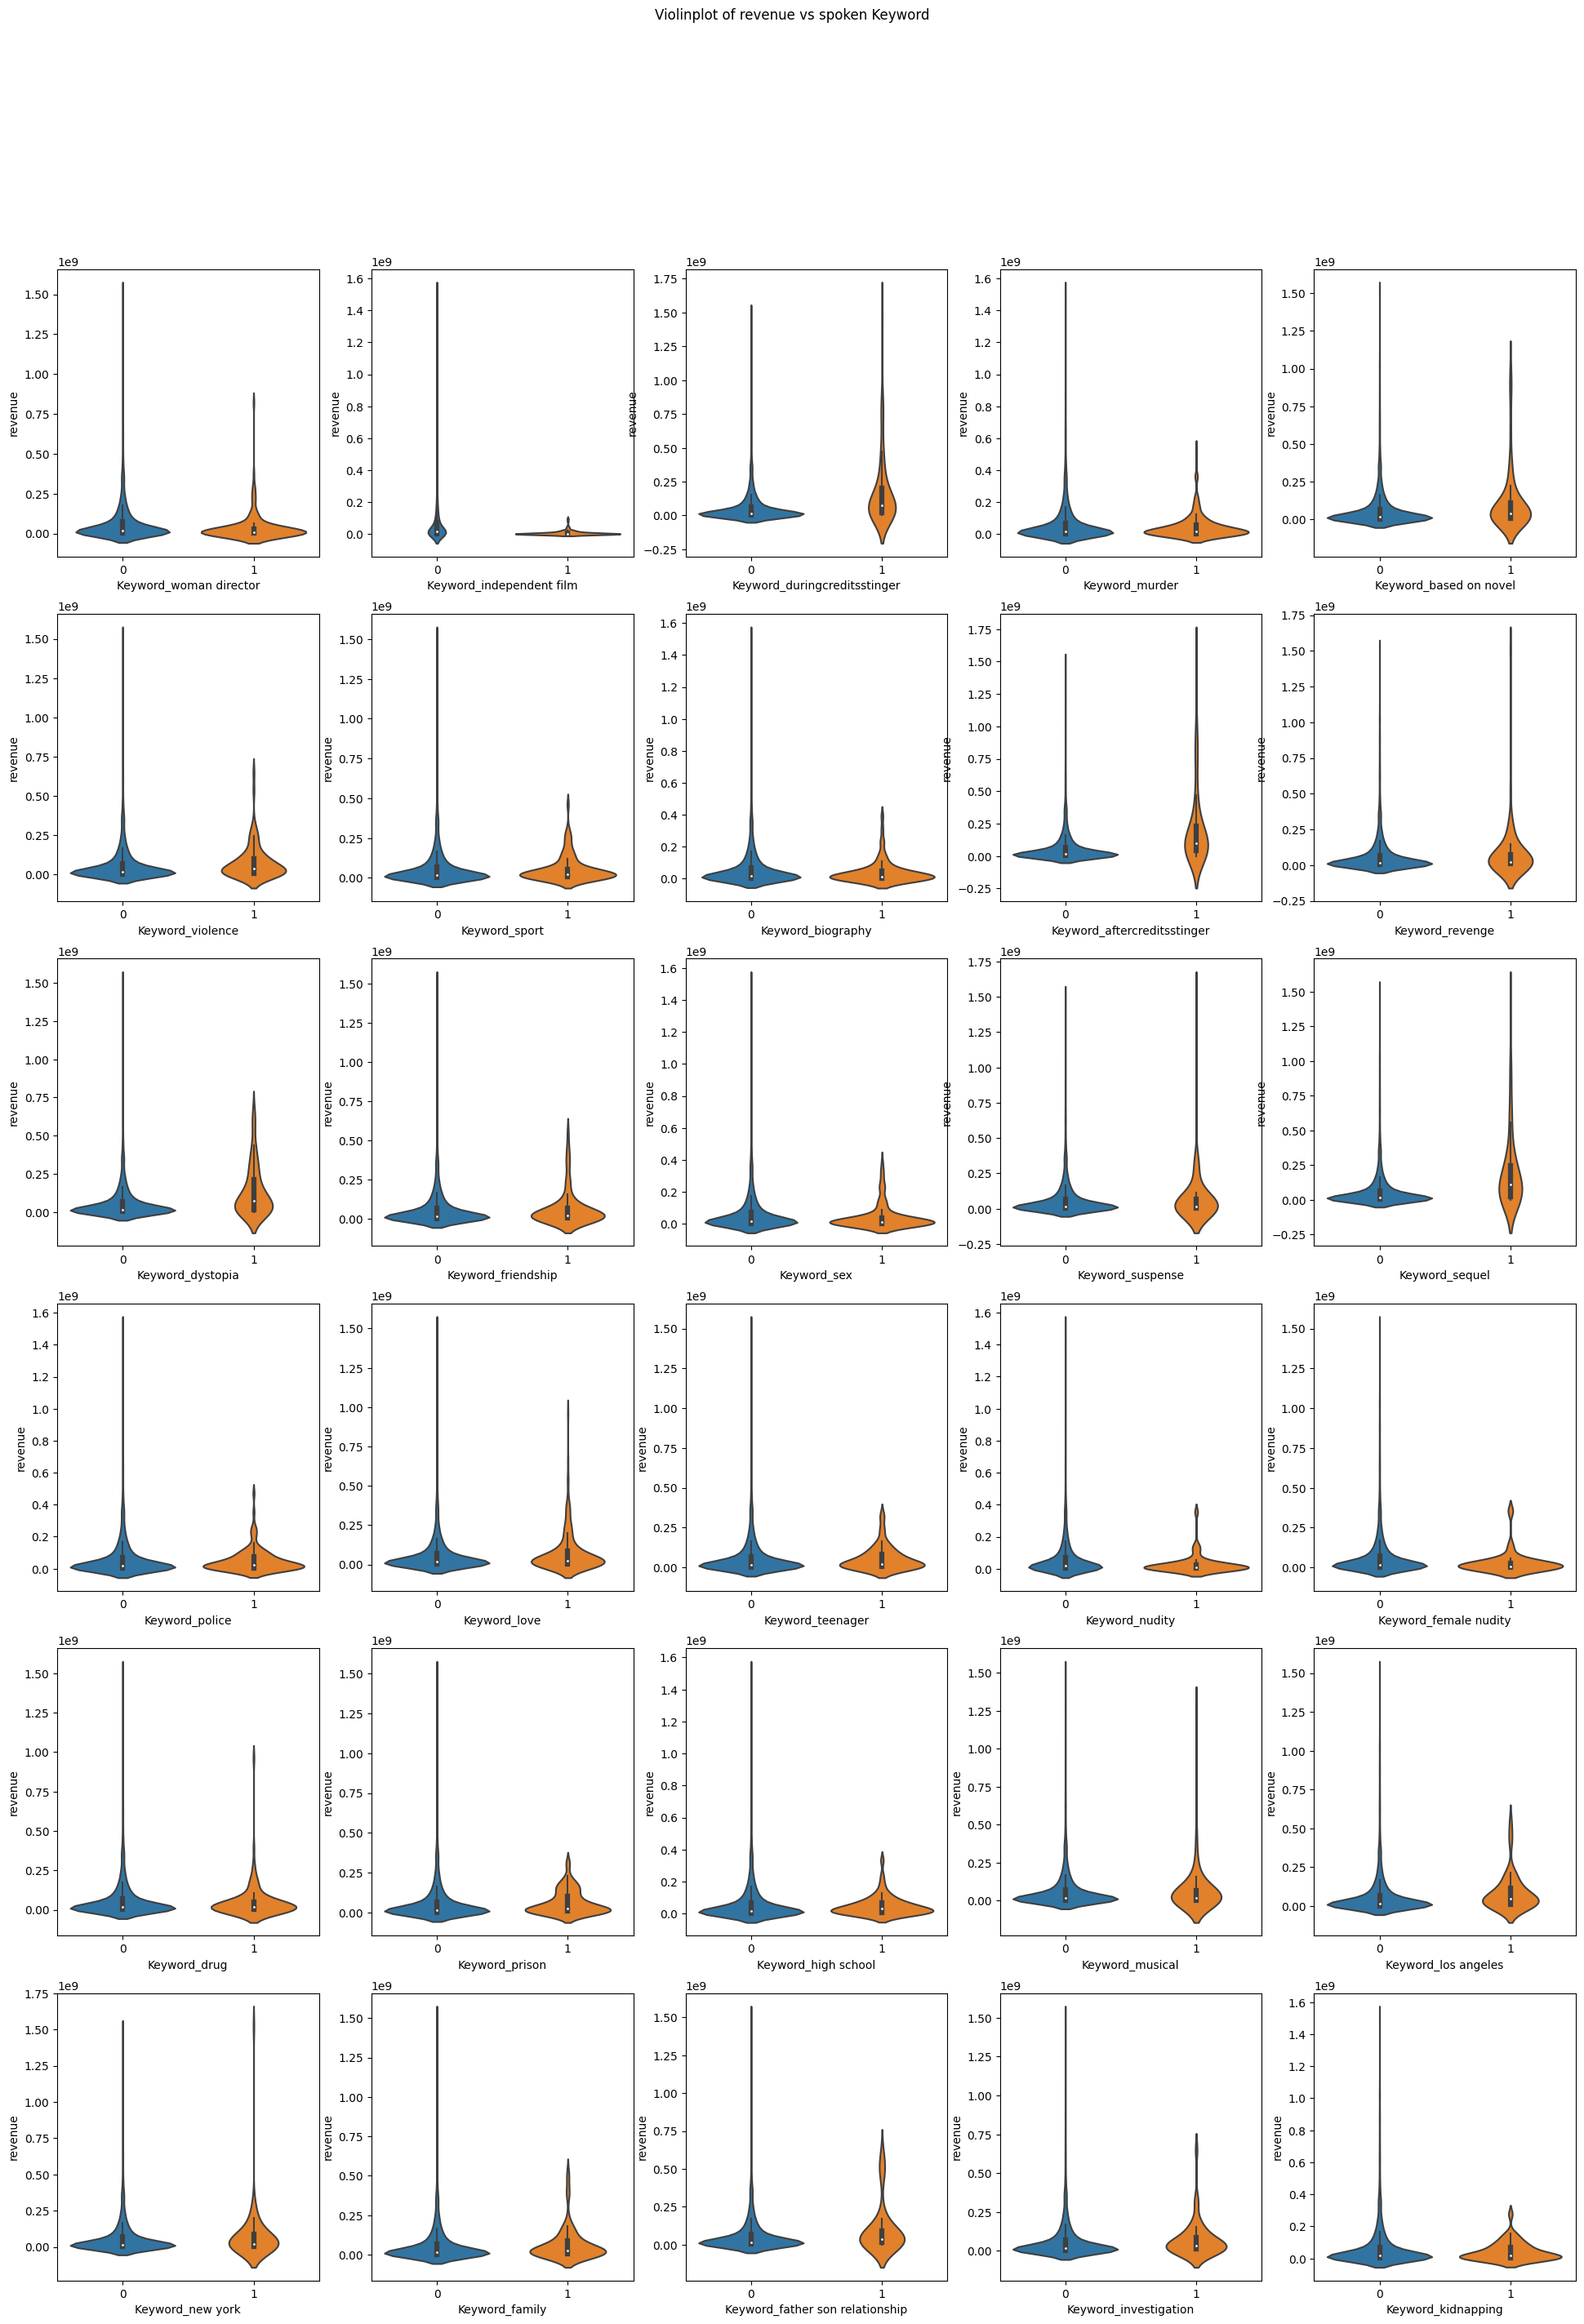

In [613]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs spoken Keyword')
for i, e in enumerate([col for col in data.columns if 'Keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

###cast

In [614]:
data['cast'] = data['cast'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["cast"][i]}')

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [615]:
info_cast = get_info_table_json(data['cast'], 'id')
info_cast

cast_id                            character                 credit_id  \
599        2.0                         Doyle Gipson  52fe42fbc3a36847f80317b1   
8016       1.0                        Dwight Hansen  52fe4492c3a36847f809dcd1   
758        3.0                           Billy Ford  52fe4469c3a36847f80949bd   
2213       1.0                         Joshep Blake  52fe438cc3a36847f805cb53   
2615       1.0                                voice  52fe44d99251416c9101eed7   
...        ...                                  ...                       ...   
25789     10.0                Captain Perry Vickers  52fe4668c3a36847f80fd535   
25790     11.0                Sir Charles Macefield  52fe4668c3a36847f80fd539   
25795     27.0  Major Jowett (as G. P. Huntley Jr.)  52fe4668c3a36847f80fd575   
25796     17.0                  Count Igor Volonoff  52fe4668c3a36847f80fd54d   
61831     79.0                     Helicopter Pilot  57bde91fc3a36818c5001823   

       gender         id               name  order  \
599       2.0     2231.0  Samuel L. Jackson    1.0   
8016      2.0      380.0     Robert De Niro    0.0   
758       2.0      192.0     Morgan Freeman    2.0   
2213      2.0       62.0       Bruce Willis    0.0   
2615      2.0     3896.0        Liam Neeson    0.0   
...       ...        ...                ...    ...   
25789     2.0     8726.0     Patric Knowles    2.0   
25790     2.0    81934.0   Henry Stephenson    3.0   
25795     0.0   120821.0       G.P. Huntley    8.0   
25796     2.0    88672.0      Robert Barrat    9.0   
61831     2.0  1669797.0    Cherokee Walker   28.0   

                           profile_path  duplicate_count  
599    /AvCReLikjzYEf9XjTQxbv3JWgKT.jpg               30  
8016   /lvTSwUcvJRLAJ2FB5qFaukel516.jpg               30  
758    /oGJQhOpT8S1M56tvSsbEBePV5O1.jpg               27  
2213   /2B7RySy2WMVJKKEFN2XA3IFb8w0.jpg               25  
2615   /9mdAohLsDu36WaXV2N3SQ388bvz.jpg               25  
...                                 ...              ...  
25789  /nnfyDm40s2buFc5tEZe25Ded2Ua.jpg                1  
25790  /wZgaeGbsFPCWfbnQJemCcpPCNAo.jpg                1  
25795  /heZ2zGeeh8EgH4MG5I6jLqGTvSg.jpg                1  
25796  /hP59p1hbbBizWea0ayGoCXjY8r5.jpg                1  
61831  /dhKQTMgLF9d585kQlA0q08tIIot.jpg                1  

[24664 rows x 9 columns]

In [616]:
data['cast_name'] = get_items_from_json('name', 'cast')
new_columns = pd.DataFrame(index=data.index)
for g in info_cast['name'][:30]:
    new_columns['cast_name_' + g] = data['cast_name'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

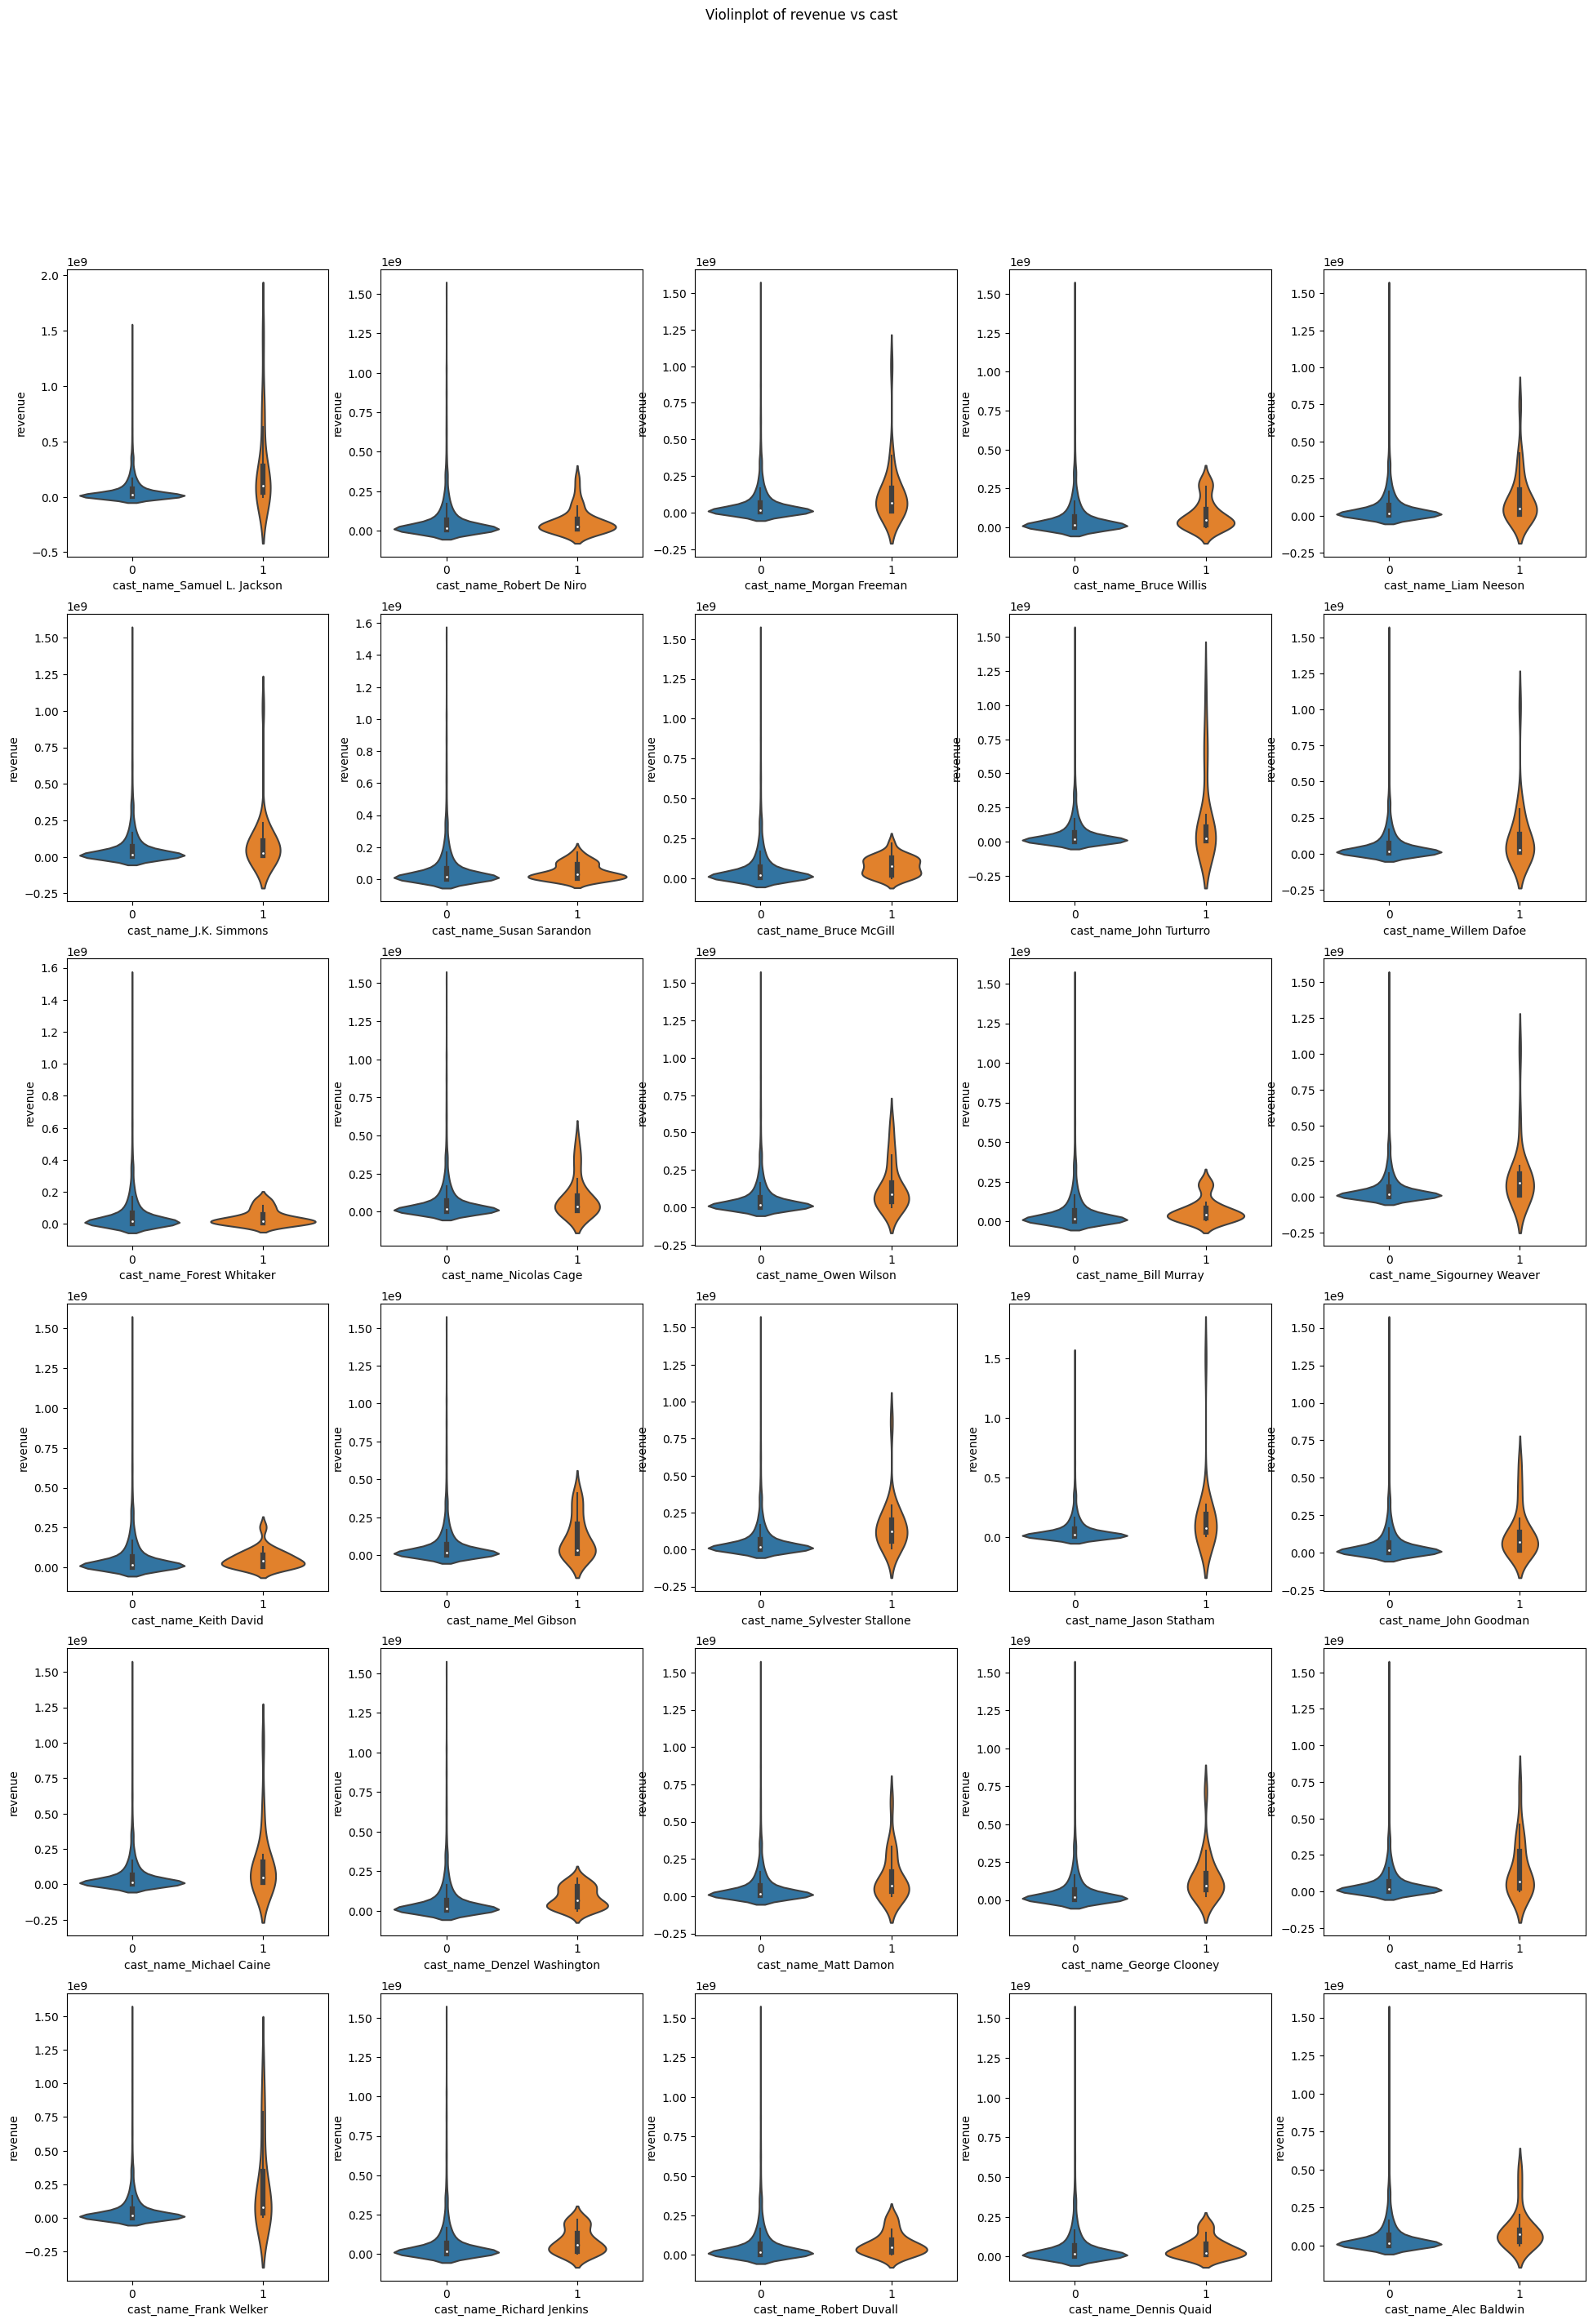

In [617]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in data.columns if 'cast_name_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

###crew

In [618]:
data['crew'] = data['crew'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["crew"][i]}')

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [619]:
info_crew = get_info_table_json(data['crew'], 'id')
info_crew

credit_id  department  gender       id  \
4510   5555cccac3a368777400233e  Production     1.0   2952.0   
2453   56a517709251410c080054d2        Crew     2.0   2294.0   
2145   52fe435fc3a36847f804f747  Production     1.0   3965.0   
1191   52fe446ac3a36847f8094a11       Sound     2.0   1213.0   
7100   52fe4957c3a368484e1269f5  Production     1.0   5914.0   
...                         ...         ...     ...      ...   
31994  52fe433ac3a36847f8043ed3   Directing     2.0  21931.0   
31970  553f242b92514138a900bcdd     Writing     1.0  32501.0   
31856  52fe44b2c3a368484e031a57     Writing     2.0   9051.0   
31847  52fe447fc3a36847f8099a59   Directing     0.0  43141.0   
72971  52fe443a9251416c7502d597  Production     1.0  16935.0   

                           job                 name  \
4510                   Casting          Avy Kaufman   
2453                    Thanks     Robert Rodriguez   
2145                   Casting       Deborah Aquila   
1191   Original Music Composer  James Newton Howard   
7100                   Casting         Mary Vernieu   
...                        ...                  ...   
31994                 Director          Chris Nahon   
31970                   Writer       Pascale Ferran   
31856                   Author        L. Frank Baum   
31847                 Director          Pete Travis   
72971                 Producer          Geena Davis   

                           profile_path  duplicate_count  
4510   /yQPGktsmkKkhkOQAUlmYlxHJOiJ.jpg               50  
2453   /bPqRdLWWwpOT8sBdj9PWOzNgwou.jpg               44  
2145   /7OBiqW30sXcW4f2xMds53L4JBN5.jpg               40  
1191   /5UTEMYS7rydwe7ooOmj2dLRFuu2.jpg               39  
7100   /rluDG0SLCvh3rVkMMp44C31iHIN.jpg               38  
...                                 ...              ...  
31994  /5ei81yfFCVBPdDw8AntZPM1U0Jy.jpg                1  
31970  /ziRiEtYYtOGb68b9bpzSKi14Wmt.jpg                1  
31856  /71j62WM8z6XN1DXnSv4AWjMUxJS.jpg                1  
31847  /xHxcow0RqzkTM2vwgfnpOT2FoSe.jpg                1  
72971  /6b8cRJOItz7yNpYuLCPkl5kv4m2.jpg                1  

[4190 rows x 8 columns]

In [620]:
data['crew_name'] = get_items_from_json('name', 'crew')
new_columns = pd.DataFrame(index=data.index)
for g in info_crew['name'][:30]:
    new_columns['crew_name_' + g] = data['crew_name'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

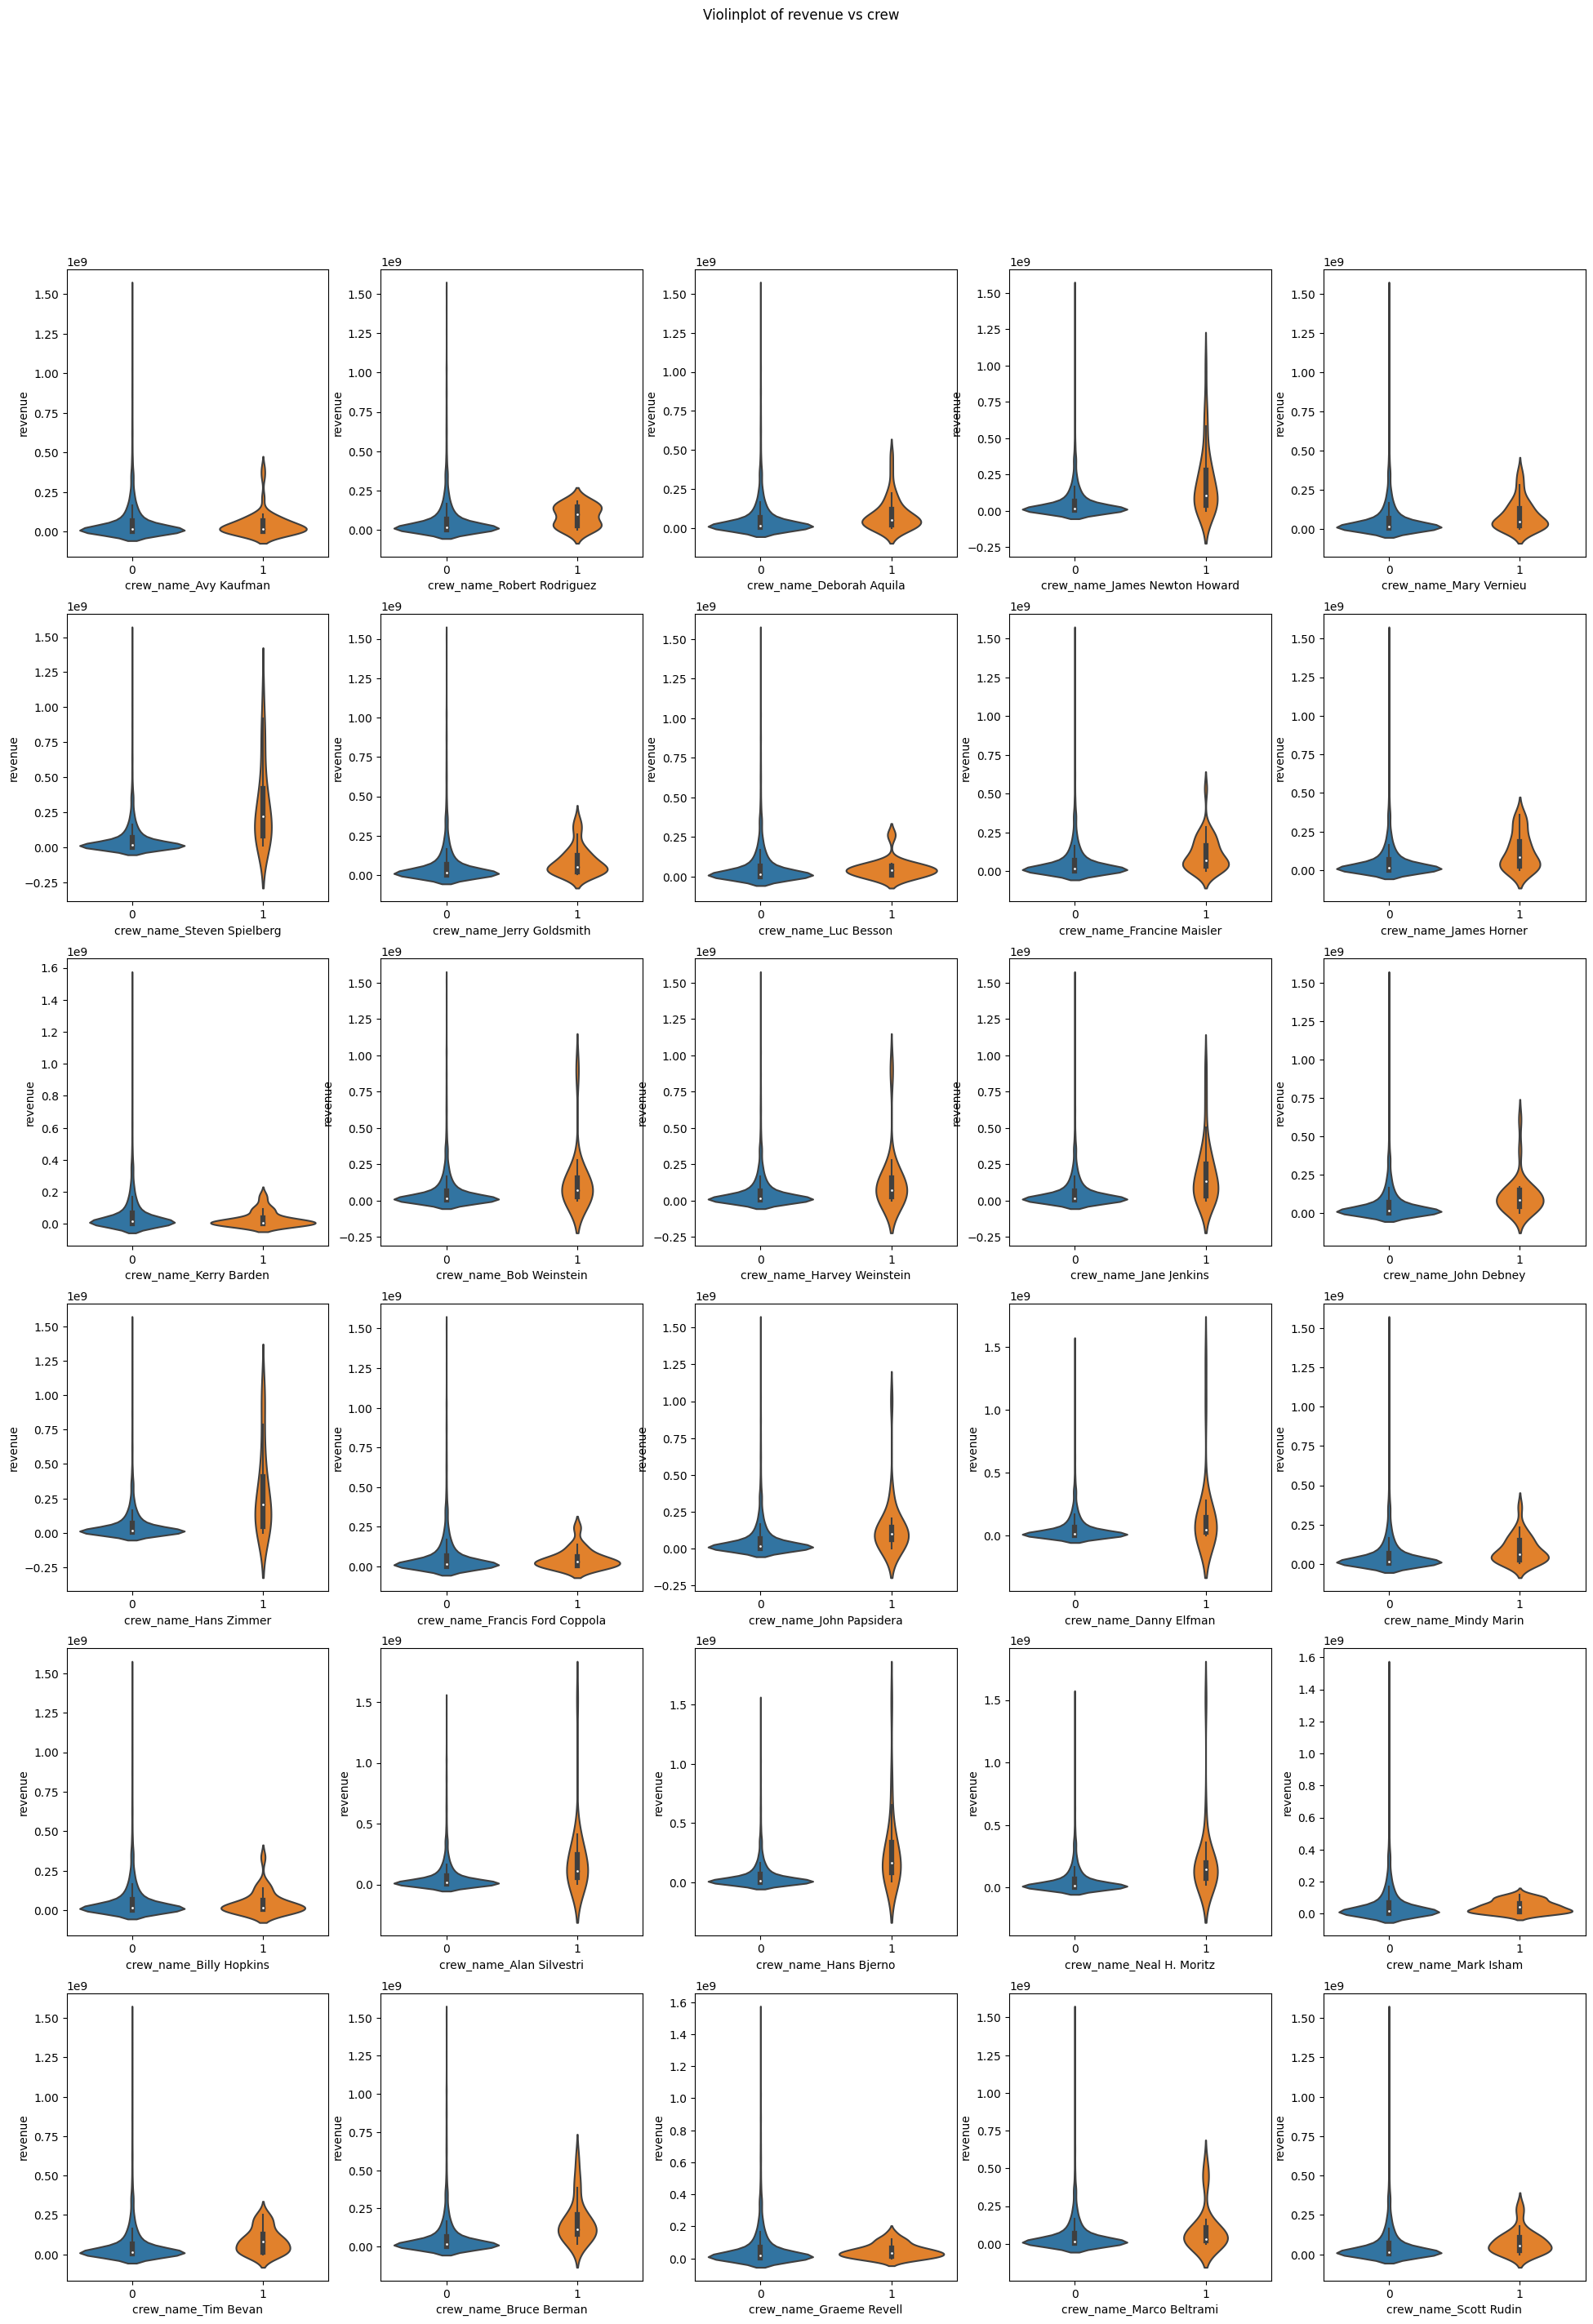

In [621]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs crew')
for i, e in enumerate([col for col in data.columns if 'crew_name_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

##Target

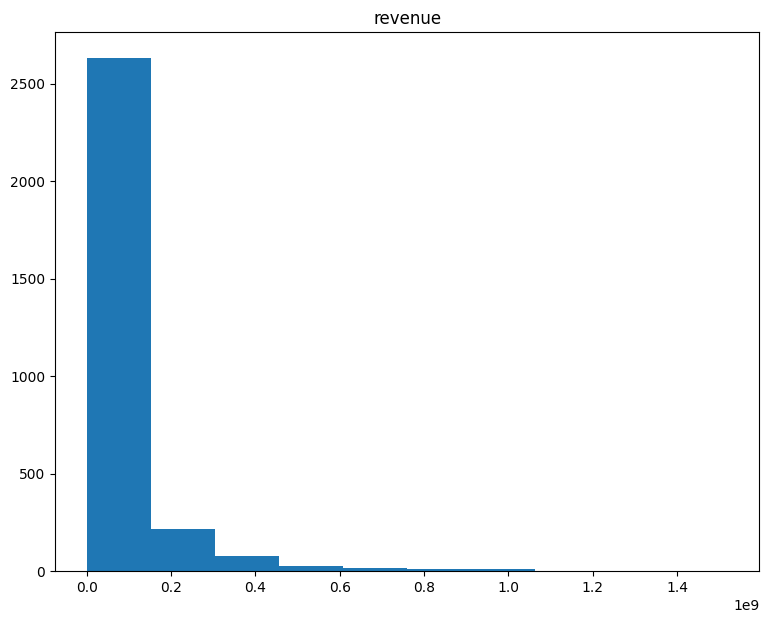

In [622]:
plt.subplots(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.hist(data['revenue']);
plt.title('revenue');

Данные сильно смещены к нулю, применим np.log1p для нормализации данных

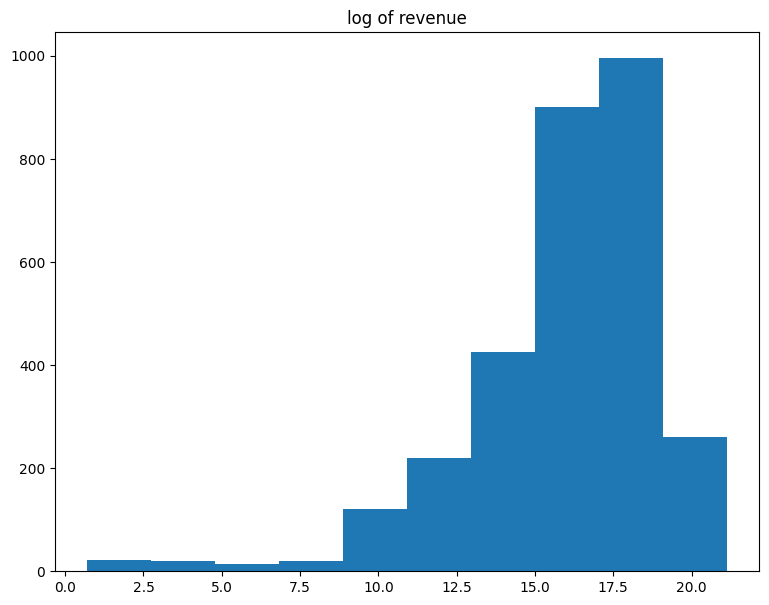

In [623]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.subplot(1, 2, 2)
plt.hist(np.log1p(data['revenue']));
plt.title('log of revenue');

Теперь выглядит хорошо, оставляем)

In [624]:
data['log_revenue'] = np.log1p(data['revenue'])

###Бюджет

То же самое сделаем с бюджетом

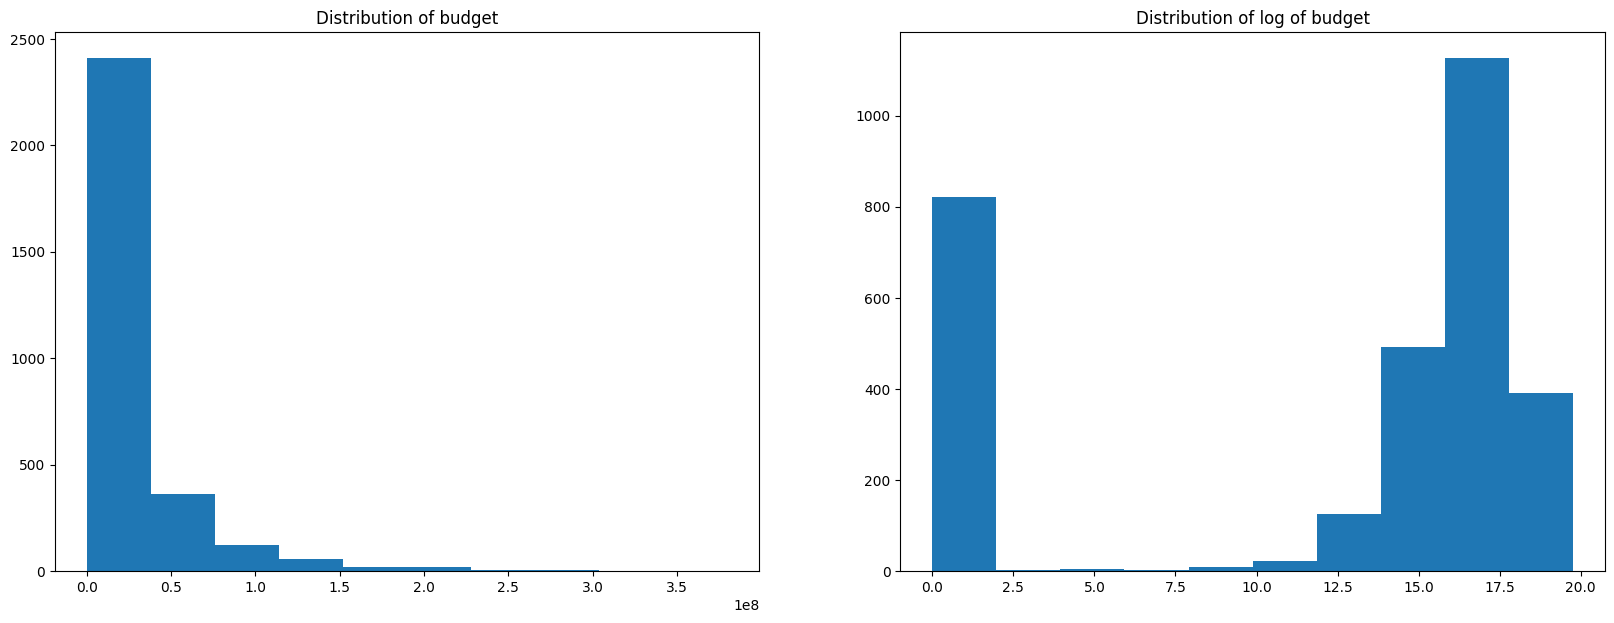

In [625]:
data['log_budget'] = np.log1p(data['budget'])
plt.subplots(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.hist(data['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(data['log_budget']);
plt.title('Distribution of log of budget');

Столбик у нуля это часть строк, где бюджет изначально был нудем

##Теперрь рассмотрим Колонки с текстом


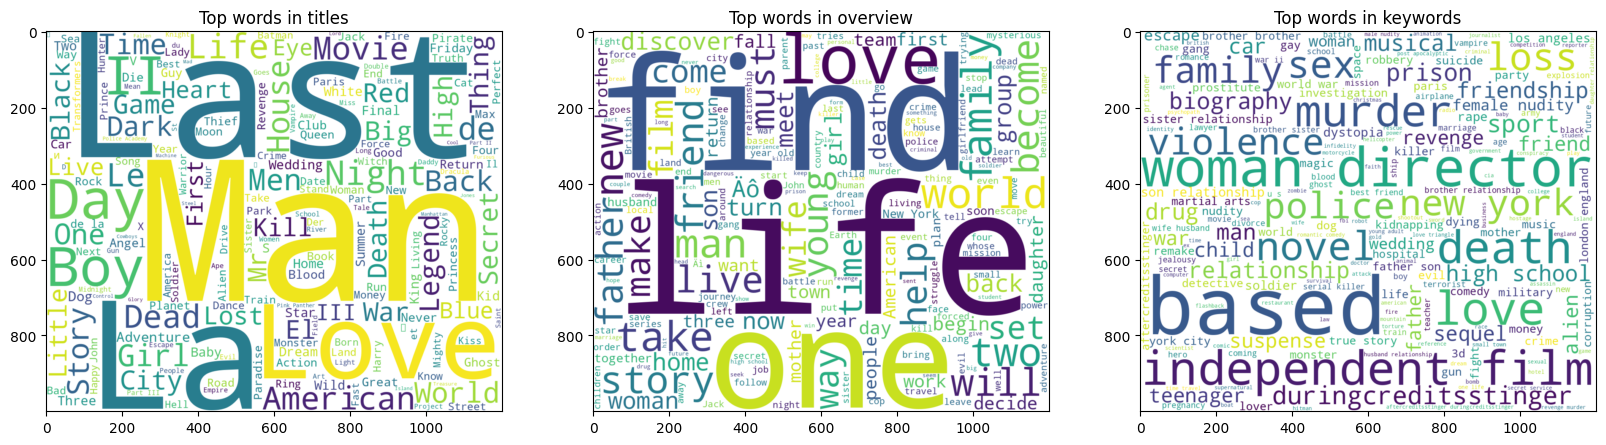

In [626]:
text_title = ' '.join(data['original_title'].values)
wordcloud_title = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text_title)
text_overview = ' '.join(data['overview'].fillna('').values)
wordcloud_overview = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text_overview)
text_keywords = ' '.join(data['Keywords_name'].fillna('').values)
wordcloud_keywords = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text_keywords)

plt.subplots(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Top words in titles')
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_overview, interpolation='bilinear')
plt.title('Top words in overview')
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_keywords, interpolation='bilinear')
plt.title('Top words in keywords')
plt.show()

Выглядит так, как будто бы нужно рассматривать все эти колонки, потому что разные популярные слова

In [627]:
data['title'] = data['title'].fillna('')
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            stop_words='english',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=15)
X = vectorizer.fit_transform(data['title'])
feature_names = vectorizer.get_feature_names_out()

tfidf_matrix = pd.DataFrame(data=X.toarray(), columns=feature_names+'_title')
data = pd.concat([data, tfidf_matrix], axis=1)
tfidf_matrix

2_title  3_title  american_title  big_title  city_title  day_title  \
0         1.0      0.0             0.0        0.0         0.0        0.0   
1         1.0      0.0             0.0        0.0         0.0        0.0   
2         0.0      0.0             0.0        0.0         0.0        0.0   
3         0.0      0.0             0.0        0.0         0.0        0.0   
4         0.0      0.0             0.0        0.0         0.0        0.0   
...       ...      ...             ...        ...         ...        ...   
2995      0.0      0.0             0.0        0.0         0.0        0.0   
2996      0.0      0.0             0.0        0.0         0.0        0.0   
2997      0.0      0.0             0.0        0.0         0.0        0.0   
2998      0.0      0.0             0.0        0.0         0.0        0.0   
2999      0.0      0.0             0.0        0.0         0.0        0.0   

      dead_title  house_title  ii_title  life_title  love_title  man_title  \
0            0.0          0.0       0.0         0.0         0.0        0.0   
1            0.0          0.0       0.0         0.0         0.0        0.0   
2            0.0          0.0       0.0         0.0         0.0        0.0   
3            0.0          0.0       0.0         0.0         0.0        0.0   
4            0.0          0.0       0.0         0.0         0.0        0.0   
...          ...          ...       ...         ...         ...        ...   
2995         0.0          0.0       0.0         0.0         0.0        0.0   
2996         0.0          0.0       0.0         0.0         0.0        0.0   
2997         0.0          0.0       0.0         0.0         0.0        0.0   
2998         0.0          0.0       0.0         0.0         0.0        0.0   
2999         0.0          0.0       0.0         0.0         0.0        0.0   

      movie_title  night_title  red_title  s_title  story_title  
0             0.0          0.0        0.0      0.0          0.0  
1             0.0          0.0        0.0      0.0          0.0  
2             0.0          0.0        0.0      0.0          0.0  
3             0.0          0.0        0.0      0.0          0.0  
4             0.0          0.0        0.0      0.0          0.0  
...           ...          ...        ...      ...          ...  
2995          0.0          0.0        0.0      0.0          0.0  
2996          0.0          0.0        0.0      0.0          0.0  
2997          0.0          0.0        0.0      0.0          0.0  
2998          0.0          0.0        0.0      0.0          0.0  
2999          0.0          0.0        0.0      0.0          0.0  

[3000 rows x 17 columns]

In [628]:
data['overview'] = data['overview'].fillna('')
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            stop_words='english',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=200)
X = vectorizer.fit_transform(data['overview'])
feature_names = vectorizer.get_feature_names_out()

tfidf_matrix = pd.DataFrame(data=X.toarray(), columns=feature_names+'overview')
data = pd.concat([data, tfidf_matrix], axis=1)

tfidf_matrix

familyoverview  fatheroverview  findsoverview  lifeoverview  \
0                0.0        0.706173       0.000000      0.000000   
1                0.0        0.000000       0.000000      1.000000   
2                0.0        0.000000       0.000000      0.000000   
3                0.0        0.000000       0.000000      1.000000   
4                0.0        0.000000       0.736745      0.000000   
...              ...             ...            ...           ...   
2995             0.0        0.000000       0.000000      0.000000   
2996             0.0        0.000000       0.000000      0.000000   
2997             0.0        0.000000       0.000000      1.000000   
2998             0.0        0.000000       0.000000      0.701014   
2999             0.0        0.000000       0.000000      0.523415   

      loveoverview  manoverview  newoverview  soverview  storyoverview  \
0              0.0     0.000000          0.0   0.000000       0.000000   
1              0.0     0.000000          0.0   0.000000       0.000000   
2              0.0     0.000000          0.0   0.000000       0.000000   
3              0.0     0.000000          0.0   0.000000       0.000000   
4              0.0     0.000000          0.0   0.000000       0.676171   
...            ...          ...          ...        ...            ...   
2995           0.0     0.000000          0.0   1.000000       0.000000   
2996           0.0     0.000000          0.0   0.000000       0.000000   
2997           0.0     0.000000          0.0   0.000000       0.000000   
2998           0.0     0.000000          0.0   0.516995       0.000000   
2999           0.0     0.617935          0.0   0.000000       0.000000   

      timeoverview  worldoverview  youngoverview  
0         0.708039       0.000000        0.00000  
1         0.000000       0.000000        0.00000  
2         0.000000       0.000000        1.00000  
3         0.000000       0.000000        0.00000  
4         0.000000       0.000000        0.00000  
...            ...            ...            ...  
2995      0.000000       0.000000        0.00000  
2996      0.000000       0.000000        0.00000  
2997      0.000000       0.000000        0.00000  
2998      0.000000       0.491217        0.00000  
2999      0.000000       0.000000        0.58668  

[3000 rows x 12 columns]

##Разделим дату на год и месяц релиза

In [629]:
data['release_date'] = pd.to_datetime(data['release_date'])
data['year'] = data['release_date'].dropna()
data['month'] = data['release_date'].dropna()
data['year'] = data['release_date'].dt.year.astype('Int64')
data.loc[data['year'] > 2023, 'year'] -= 100
data['month'] = data['release_date'].dt.month.astype('Int64')

##Категориальные переменные

In [630]:
for col in ['original_language', 'collection_name']:
    le = LabelEncoder()
    le.fit(list(data[col].fillna('')))
    data[col] = le.transform(data[col].fillna('').astype(str))

##Почистим таблицу

In [631]:
pd.set_option('display.max_columns', None)
data

id                              belongs_to_collection    budget  \
0        1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1        2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2        3                                                 []   3300000   
3        4                                                 []   1200000   
4        5                                                 []         0   
...    ...                                                ...       ...   
2995  2996                                                 []         0   
2996  2997                                                 []         0   
2997  2998                                                 []  65000000   
2998  2999                                                 []  42000000   
2999  3000                                                 []  35000000   

                                                 genres  \
0                        [{'id': 35, 'name': 'Comedy'}]   
1     [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                         [{'id': 18, 'name': 'Drama'}]   
3     [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
...                                                 ...   
2995  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2996  [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...   
2997  [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...   
2998  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2999  [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...   

                               homepage    imdb_id  original_language  \
0                                   NaN  tt2637294                  7   
1                                   NaN  tt0368933                  7   
2     http://sonyclassics.com/whiplash/  tt2582802                  7   
3            http://kahaanithefilm.com/  tt1821480                 13   
4                                   NaN  tt1380152                 18   
...                                 ...        ...                ...   
2995                                NaN  tt0109403                  7   
2996                                NaN  tt2364975                 29   
2997                                NaN  tt0116908                  7   
2998     http://www.alongcamepolly.com/  tt0343135                  7   
2999   http://www.abductionthefilm.com/  tt1600195                  7   

                                original_title  \
0                       Hot Tub Time Machine 2   
1     The Princess Diaries 2: Royal Engagement   
2                                     Whiplash   
3                                      Kahaani   
4                                         마린보이   
...                                        ...   
2995                                   Chasers   
2996                               Vi är bäst!   
2997                   The Long Kiss Goodnight   
2998                          Along Came Polly   
2999                                 Abduction   

                                               overview  popularity  \
0     When Lou, who has become the "father of the In...    6.575393   
1     Mia Thermopolis is now a college graduate and ...    8.248895   
2     Under the direction of a ruthless instructor, ...   64.299990   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4     Marine Boy is the story of a former national s...    1.148070   
...                                                 ...         ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542   
2999  A young man sets out to uncover the truth abou...   10.512109   

                           poster_path  \
0     /tQtWuwvMf0hCc2QR2t

In [636]:
#data = data.drop(columns = ['id', 'belongs_to_collection', 'genres', 'homepage', 'imdb_id', 'original_title', 'overview', 'poster_path', 'production_companies', 'production_countries', 'production_countries_id', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'genres_names', 'production_companies_names', 'Keywords_name', 'cast_name', 'crew_name'], axis = 1)
data = data.drop(['spoken_languages_id'], axis = 1)
data

budget  original_language  popularity  runtime    revenue  \
0     14000000                  7    6.575393     93.0   12314651   
1     40000000                  7    8.248895    113.0   95149435   
2      3300000                  7   64.299990    105.0   13092000   
3      1200000                 13    3.174936    122.0   16000000   
4            0                 18    1.148070    118.0    3923970   
...        ...                ...         ...      ...        ...   
2995         0                  7    9.853270    102.0    1596687   
2996         0                 29    3.727996    102.0     180590   
2997  65000000                  7   14.482345    120.0   89456761   
2998  42000000                  7   15.725542     90.0  171963386   
2999  35000000                  7   10.512109    106.0   82087155   

      collection_name  has_collection  genre_Drama  genre_Comedy  \
0                 152               1            0             1   
1                 366               1            1             1   
2                   1               0            1             0   
3                   1               0            1             0   
4                   1               0            0             0   
...               ...             ...          ...           ...   
2995                1               0            0             1   
2996                1               0            1             0   
2997                1               0            0             0   
2998                1               0            0             1   
2999                1               0            0             0   

      genre_Thriller  genre_Action  genre_Romance  genre_Crime  \
0                  0             0              0            0   
1                  0             0              1            0   
2                  0             0              0            0   
3                  1             0              0            0   
4                  1             1              0            0   
...              ...           ...            ...          ...   
2995               0             0              1            0   
2996               0             0              0            0   
2997               1             1              0            1   
2998               0             0              1            0   
2999               1             1              0            0   

      genre_Adventure  genre_Horror  genre_Science Fiction  genre_Family  \
0                   0             0                      0             0   
1                   0             0                      0             1   
2                   0             0                      0             0   
3                   0             0                      0             0   
4                   0             0                      0             0   
...               ...           ...                    ...           ...   
2995                0             0                      0             0   
2996                0             0                      0             0   
2997                0             0                      0             0   
2998                0             0                      0             0   
2999                0             0                      0             0   

      genre_Fantasy  genre_Mystery  genre_Animation  genre_History  genre_War  \
0                 0              0                0              0          0   
1                 0              0                0              0          0   
2                 0              0                0              0          0   
3                 0              0                0              0          0   
4                 0              0                0              0          0   
...             ...            ...              ...            ...        ...   
2995              0              0                0              0          0   
2996    

###Finish

In [659]:

data = data.dropna()
X = data.drop(['log_revenue'], axis=1)
X = data.drop(['revenue'], axis=1)
y = data['log_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Градиентный бустинг
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_mse = mean_squared_error(np.expm1(y_test), np.expm1(gb_predictions))
print(f'Gradient Boosting Mean Squared Error: {gb_mse}')

# Случайный лес
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(np.expm1(y_test), np.expm1(rf_predictions))
print(f'Random Forest Mean Squared Error: {rf_mse}')


Gradient Boosting Mean Squared Error: 7110770075894.364
Random Forest Mean Squared Error: 2160423854009.046


Эти цифры показались нам страшными, но все таки мы предсказываем сборы фильмов, а эти числа очень большие, поэтому мы обратились к другим метрикам оценки качества моделей

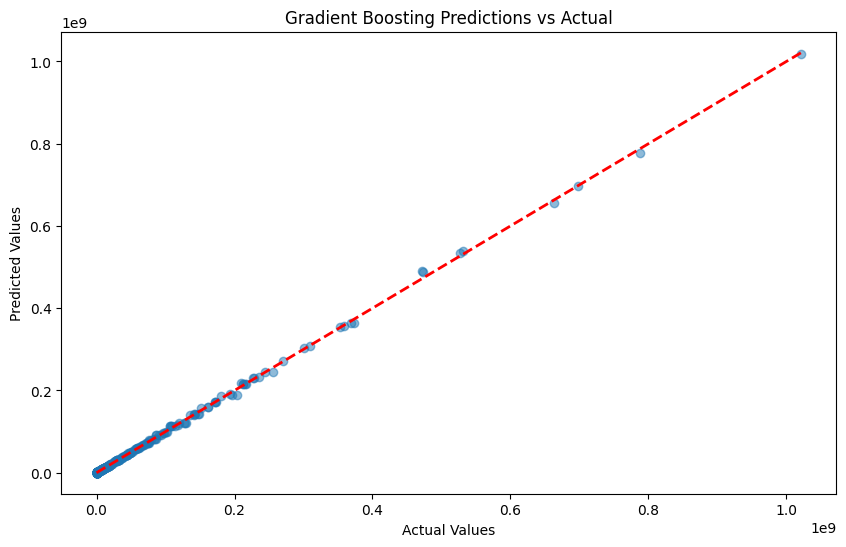

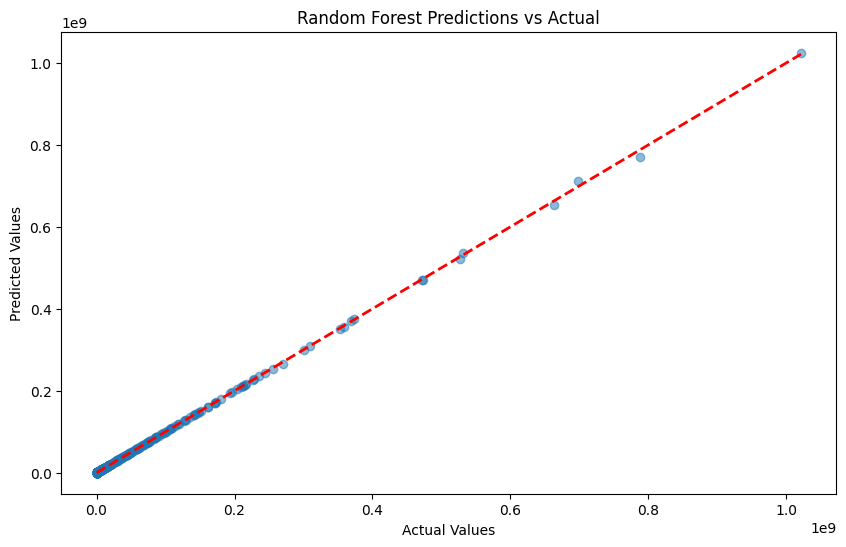

In [660]:
def plot_predictions(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], '--', color='red', linewidth=2)
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

plot_predictions(np.expm1(y_test), np.expm1(gb_predictions), 'Gradient Boosting')
plot_predictions(np.expm1(y_test), np.expm1(rf_predictions), 'Random Forest')

Тут выглядит очень хорошо

$$
R^2 = 1 - \frac{\text{SSE}}{\text{SST}}
$$

Сумма квадратов остатков (SSE) измеряет сумму квадратов разностей между фактическими значениями и предсказанными значениями.

Сумма квадратов отклонений от среднего (SST) измеряет сумму квадратов разностей между фактическими значениями и средним значением зависимой переменной.

In [664]:
gb_r2 = r2_score(np.expm1(y_test), np.expm1(gb_predictions))
print(f'Gradient Boosting R-squared: {gb_r2}')

rf_r2 = r2_score(np.expm1(y_test), np.expm1(rf_predictions))
print(f'Random Forest R-squared: {rf_r2}')

Gradient Boosting R-squared: 0.9995343456052124
Random Forest R-squared: 0.999858522937532


А тут так хорошо, что даже страшно